# (Ford GoBike - Communicate Data Findings)
## by (Moheb Maher)

## Understanding the Context

> - Bay Wheels is a regional public bicycle sharing system in California's San Francisco Bay Area.
> - It was established as Bay Area Bike Share in August 2013.
> - As of January 2018, the Bay Wheels system had over 2,600 bicycles in 262 stations across San Francisco, East Bay and San Jose.
> - In June 2017 the system was officially re-launched as Ford GoBike in a partnership with Ford Motor Company.
> - The system was renamed to Bay Wheels in June 2019.
> - The system is expected to expand to 7,000 bicycles around 540 stations in San Francisco, Oakland, Berkeley, Emeryville, and San Jose.

## Asking Questions

> - Who are Ford GoBike’s customers?
> - What are the characteristics of Customers vs. Subscribers?
> - When is the service often used? (rush hours - weekdays vs. weekends)
> - What is the average ride duration?
> - Which are the famous start and and destination station?
> - Which are the famous routes?

## Data Wrangling

### Setting the workspace

In [1]:
# Import all necessary packages:
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import pandas as pd
from pandas.api.types import CategoricalDtype
from geopy.distance import geodesic
import datetime as dt
from zipfile import ZipFile

In [2]:
# Creating & setting a customized palette:
custom_palette = ['#118ab2', '#ef476f', '#06d6a0', '#ffd166', '#073b4c']
sns.set_palette(custom_palette)

In [3]:
# The current color palette:
sns.color_palette()

[(0.06666666666666667, 0.5411764705882353, 0.6980392156862745),
 (0.9372549019607843, 0.2784313725490196, 0.43529411764705883),
 (0.023529411764705882, 0.8392156862745098, 0.6274509803921569),
 (1.0, 0.8196078431372549, 0.4),
 (0.027450980392156862, 0.23137254901960785, 0.2980392156862745)]

In [4]:
# Defining our main colors:
blue = custom_palette[0]
red = custom_palette[1]
green = custom_palette[2]

### Loading data

> - The data is available for download here:
>> https://s3.amazonaws.com/fordgobike-data/index.html
> - For the current analysis, only 2018 data is downloaded.
> - The data is in a zipped folder which contains 12 csv files, one for each month in 2018.
> - Half of the records in each file will be randomly sampled and concatenated into a single file.

In [5]:
with ZipFile(file='data.zip', mode='r') as zip:
    zip.extractall()

In [6]:
# Defining a function to load and concatenate data sets:
def load_data(folder_path):
    
    """
    This function cancatenates the datasets for all available datasets for 2018
    into a single dataset while sampling half of each dataset.
    
    Args:
    (str): The folder path in which the datasets are present.
    
    Returns:
    (DataFrame): The concatenated dataset.
    """
    import os
    files = os.listdir(f'{folder_path}')
    valid_files = [file for file in files if file.endswith('csv')]
    dfs = []
    
    for file in valid_files:
        df = pd.read_csv(f'{folder_path}/{file}')
        df = df.sample(df.shape[0]//2)
        dfs.append(df)
        
    return pd.concat(objs = dfs, ignore_index = True)

In [7]:
# Reading, sampling & concatenating data:
raw_sample_data = load_data('./data')

In [8]:
# Exporting the raw data into a csv file:
raw_sample_data.to_csv('./output/2018-fordgobike-tripdata-raw-sample.csv', index=False)

### Data assessment

#### What is the structure of your dataset?

In [9]:
# Exploring shape:
raw_sample_data.shape

(931858, 16)

In [10]:
# Exploring column labels, missing values & dtypes:
raw_sample_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 931858 entries, 0 to 931857
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   duration_sec             931858 non-null  int64  
 1   start_time               931858 non-null  object 
 2   end_time                 931858 non-null  object 
 3   start_station_id         925935 non-null  float64
 4   start_station_name       925935 non-null  object 
 5   start_station_latitude   931858 non-null  float64
 6   start_station_longitude  931858 non-null  float64
 7   end_station_id           925935 non-null  float64
 8   end_station_name         925935 non-null  object 
 9   end_station_latitude     931858 non-null  float64
 10  end_station_longitude    931858 non-null  float64
 11  bike_id                  931858 non-null  int64  
 12  user_type                931858 non-null  object 
 13  member_birth_year        876381 non-null  float64
 14  memb

> - After sampling and concatenation, the dataset has 931858 rows and 16 columns.
> - The size is enough for analysis.
> - Colum labels are satisfying (no odd characters - no extra spaces - snake cased).
> - Some columns have missing values.
> - Some columns have incorrect data types.
> - We could use some new columns (see later).

#### What is/are the main feature(s) of interest in your dataset?

In [11]:
# Exploring a slice from the data:
raw_sample_data.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,768,2018-01-12 07:42:42.3440,2018-01-12 07:55:30.6510,140.0,Cesar Chavez St at Dolores St,37.747858,-122.424986,97.0,14th St at Mission St,37.768265,-122.420110,493,Subscriber,1979.0,Female,No
1,596,2018-01-30 07:48:20.7580,2018-01-30 07:58:17.6630,27.0,Beale St at Harrison St,37.788059,-122.391865,93.0,4th St at Mission Bay Blvd S,37.770407,-122.391198,2304,Subscriber,1975.0,Male,No
2,548,2018-01-30 17:05:45.9070,2018-01-30 17:14:54.6180,44.0,Civic Center/UN Plaza BART Station (Market St ...,37.781074,-122.411738,67.0,San Francisco Caltrain Station 2 (Townsend St...,37.776639,-122.395526,557,Subscriber,NaN,NaN,No
3,536,2018-01-19 17:09:52.9770,2018-01-19 17:18:49.9180,66.0,3rd St at Townsend St,37.778742,-122.392741,15.0,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,1876,Subscriber,1977.0,Male,No
4,727,2018-01-26 09:40:30.4700,2018-01-26 09:52:38.4430,35.0,Cahill Park,37.329119,-121.904576,310.0,San Fernando St at 4th St,37.335885,-121.885660,1626,Subscriber,1995.0,Male,Yes


> - Target audience demographics (gender - age).
> - Customer behavior (rush hours, average ride duration - common stations - common routes).

#### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> - Target audience demographics: member_gender & member_birth_year.
> - Customer behavior: start_time, end_time, start_station_name, end_station_name, sunscription, coordinates.

### Data cleaning

In [12]:
# Exploring column labels, missing values & dtypes:
raw_sample_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 931858 entries, 0 to 931857
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   duration_sec             931858 non-null  int64  
 1   start_time               931858 non-null  object 
 2   end_time                 931858 non-null  object 
 3   start_station_id         925935 non-null  float64
 4   start_station_name       925935 non-null  object 
 5   start_station_latitude   931858 non-null  float64
 6   start_station_longitude  931858 non-null  float64
 7   end_station_id           925935 non-null  float64
 8   end_station_name         925935 non-null  object 
 9   end_station_latitude     931858 non-null  float64
 10  end_station_longitude    931858 non-null  float64
 11  bike_id                  931858 non-null  int64  
 12  user_type                931858 non-null  object 
 13  member_birth_year        876381 non-null  float64
 14  memb

In [13]:
raw_sample_data.describe().T

,count,mean,std,min,25%,50%,75%,max
duration_sec,931858.0,857.810430,2377.302890,61.000000,350.000000,556.000000,872.000000,86366.00
start_station_id,925935.0,119.693435,100.371803,3.000000,33.000000,89.000000,186.000000,381.00
start_station_latitude,931858.0,37.766748,0.105843,37.263310,37.771058,37.781074,37.796248,45.51
start_station_longitude,931858.0,-122.349139,0.166681,-122.473658,-122.411403,-122.397380,-122.286533,-73.57
end_station_id,925935.0,118.159894,100.413640,3.000000,30.000000,88.000000,183.000000,381.00
end_station_latitude,931858.0,37.766865,0.105724,37.263310,37.771058,37.781270,37.797280,45.51
end_station_longitude,931858.0,-122.348615,0.166275,-122.473658,-122.409449,-122.397086,-122.289370,-73.57
bike_id,931858.0,2296.263439,1286.865051,11.000000,1225.000000,2338.000000,3333.000000,6234.00
member_birth_year,876381.0,1983.075868,10.458329,1881.000000,1978.000000,1985.000000,1991.000000,2000.00


In [14]:
# Counting missing values in each column:
raw_sample_data.isna().sum()[raw_sample_data.isna().sum() != 0]

start_station_id       5923
start_station_name     5923
end_station_id         5923
end_station_name       5923
member_birth_year     55477
member_gender         55294
dtype: int64

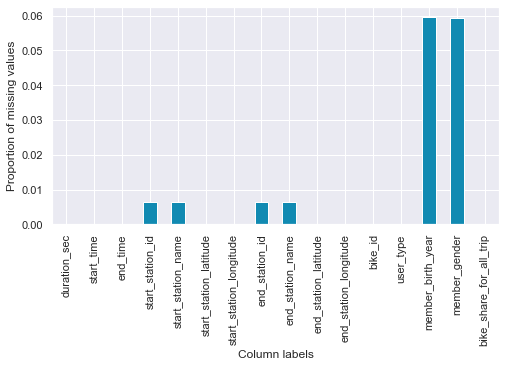

In [15]:
# Plotting the proportion of missing values in each column:
fig = plt.figure(figsize=(8, 4))
ax = raw_sample_data.isna().mean().plot.bar()
ax.set_xlabel('Column labels')
ax.set_ylabel('Proportion of missing values');

> - A relatively few proportion of rows with missing values.

In [16]:
# Searching for duplicated rows:
raw_sample_data.duplicated().sum()

0

> - No duplicated rows.

In [17]:
# Creating a copy of the original data before cleaning:
df = raw_sample_data.copy()

> - It is always a good idea to create a copy before cleaning the data.

In [18]:
# Dropping rows with missing values:
df.dropna(axis=0, inplace=True)

> - The data now has no rows with missing values or duplicates, however there are 2 issues that must be considered:
> 1. There are rows that contain the same station in start_station_name and end_station_name.
> 2. Certain age values don't make any sense (> 100 years old!).

In [19]:
# Filtering out row that have invalid enteries:
duplicated_st = df.query("start_station_id == end_station_id").index.to_list()
df.drop(labels=duplicated_st, inplace=True)

In [20]:
# Filtering out ages > 80 years old:
ages_gt_100 = df.query("member_birth_year < 1918").index.to_list()
df.drop(labels=ages_gt_100, inplace=True)

> - The data is now clean and ready for creating some new features.

In [21]:
# Converting start time and end time into datetime format:
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])

> - The "when" in data often leads to "why", so it is crucial to convert the start_time and end_time to proper datetime format.

In [22]:
# Creating a new column for the hour:
df['hour'] = df['start_time'].dt.strftime('%H')

# Putting hours in the correct order:
hours = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12',
         '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '00']

# Creating an ordered hours CategoricalDtype:
hours_cat = CategoricalDtype(categories=hours, ordered=True)

# Setting dtype of hours columns:
df['hour'] = df['hour'].astype(hours_cat)

> - Now we have a column for hours as an ordered categorical feature.

In [23]:
# Creating a new column for the weekday:
df['weekday'] = df['start_time'].dt.strftime('%A')

# Putting weekdays in the correct order:
weekdays = ['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

# Creating an ordered weekdays CategoricalDtype:
weekdays_cat = CategoricalDtype(categories=weekdays, ordered=True)

# Setting dtype of weekdays columns:
df['weekday'] = df['weekday'].astype(weekdays_cat)

> - Now we have a column for weekday as an ordered categorical feature.

In [24]:
# Defining a function to deterime if the day is weekday or weekend:
def check_day(day):
    
    """
    This function checks if the day is weekday or weekend.
    
    Args:
    (str): The weekday.
    
    Returns:
    (str): Type of the day.
    """    
    
    if day in ['Saturday', 'Sunday']:
        type_of_day = 'Weekend'
        
    else:
        type_of_day = 'Weekday'
        
    return type_of_day        

In [25]:
# Creating a new column for the weekday & setting its dtype as category:
df['type_of_day'] = df['weekday'].apply(check_day)
df['type_of_day'] = df['type_of_day'].astype('category')

> - Creating a column for type_of_day will help later in the analysis process.

In [26]:
# Creating a new column for the month:
df['month'] = df['start_time'].dt.strftime('%B')

# Putting months in the correct order:
months = ['January', 'February', 'March', 'April', 'May', 'June',
          'July', 'August', 'September', 'October', 'November', 'December']

# Creating an ordered months CategoricalDtype:
months_cat = CategoricalDtype(categories=months, ordered=True)

# Setting dtype of months columns:
df['month'] = df['month'].astype(months_cat)

> - Now we have a column for month as an ordered categorical feature.

In [27]:
# Creating a new column for the current age:
df['age'] = (2018 - df['member_birth_year']).astype('int')

# Binning ages into groups:
age_bins = ['Young', 'Young adult', 'Middle-aged adult', 'Elderly-adult', 'Senior']
df['age_group'] = pd.cut(df['age'], bins=[0, 25, 35, 50, 65, 100], labels=age_bins)

> - Understanding the audience demographics will help in buidling our cusomer persona.

In [28]:
# Creating a new column for the duration in rounded minutes:
df['duration_min'] = (df['end_time'] - df['start_time']).dt.seconds // 60

> - Since pricing is dependent on the duraion between start_time and end_time, it may be a good idea to have a column for duraion in minutes.
> - When I compared the result of substraction with the duration_sec column I found some differences, so I made my own column for duration_m.

In [29]:
# Creating a new column for the whole trip:
df['trip'] = df['start_station_name'] + ' | ' + df['end_station_name']

> - Having a column for trip will come in handy for determining the most common trips.
> - However, there is a certain caveat here. Since the ordinary user is expected to have daily fixed trips, some routes - regardless of direction -  may be counted twice, this will be handled later.

In [30]:
# Creating a column for all coordinates in str format:
df['coordinates'] = (df['start_station_latitude'].astype(str) + ', ' +
                     df['start_station_longitude'].astype(str) + ', ' +
                     df['end_station_latitude'].astype(str) + ', ' +
                     df['end_station_longitude'].astype(str))

> - This is a temporary column which will be used for computing distances.

In [31]:
# Defining a function that uses geopy module to compute distance between 2 coordinates:
def compute_distance(coordinates):
    
    """
    This function takes a pair of coordinates if the form of a str and returns
    the distance between the 2 points.
    
    Args:
    (str): The pair of coordinates.
    
    Returns:
    (float): The distance between the 2 points.
    """    
    
    coordinates = eval(coordinates)
    strt_lat, strt_long, end_lat, end_long = coordinates
    
    return geodesic((strt_lat, strt_long), (end_lat, end_long)).m

In [32]:
# Applying the former function to create a new column for distance in m:
df['distance_m'] = df['coordinates'].apply(compute_distance) // 1

> - This function doesn't take into account that the real distance in most cases will not equal the distance between 2 points. It may be a good approximation though

In [33]:
# Converting age & duration into int columns:
df[['duration_min', 'distance_m']] = df[['duration_min', 'distance_m']].astype('int')

In [34]:
# Converting member gender into category:
df['member_gender'] = df['member_gender'].astype('category')

In [35]:
# Dropping redundant columns:
cols_to_drop = ['duration_sec', 'member_birth_year', 'coordinates',
                'start_station_id', 'end_station_id','bike_id' ]

df.drop(axis=1, labels=cols_to_drop, inplace=True)

> - Polishing the data.

In [36]:
# Exporting the ready-to-explore data into a csv file:
df.to_csv('./output/2018-fordgobike-tripdata-ready-sample.csv', index=False)

> - <font color='red'>**It is crucial to run this step, this exported file will be used for the slide deck analysis.**</font>

## Exploratory Data Analysis

### Univariate Exploration

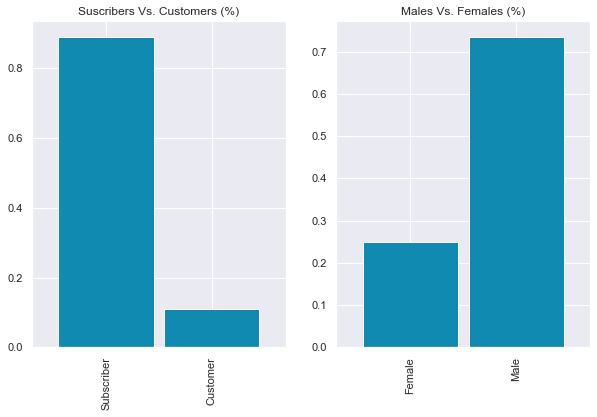

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

ax1.set_title('Suscribers Vs. Customers (%)')
df['user_type'].value_counts(normalize=True).plot.bar(color=blue, width=0.9, ax=ax1)

ax2.set_title('Males Vs. Females (%)')
labels = ['Female', 'Male']
gens = df['member_gender'].value_counts(normalize=True).loc[labels]
gens.plot.bar(color=blue, tick_label=labels, width=0.9, ax=ax2);

> - since there is no user id column, we can't guarantee that these counts represent unique individuals.
> - Since subscribers usually use any service more often, I think that subscribers and cusomers must be weighted differently and it will be crucial to segment our audience later on.
> - All we can conclude that:
>> 1. The service is being used by subscribers about 8 times more often than ordinary customers.
>> 2. The service is being used by males about 3 times more often than females.

In [38]:
df['age'].describe([0.99]).T

count    849069.000000
mean         34.871589
std          10.209165
min          18.000000
50%          33.000000
99%          64.000000
max          98.000000
Name: age, dtype: float64

> - It is always a good ideia to combine the power of numbers & visuals, we can use these statistics to guide our plotting.

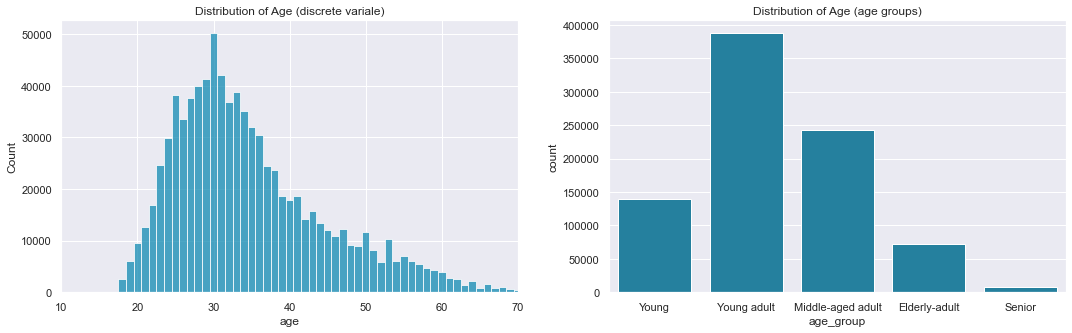

In [39]:
# Plotting the distribution of age (discrete variable - groups):
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

ax1.set_title('Distribution of Age (discrete variale)')
ax1.set_xlim(10, 70) # Limits are based on summary stats
sns.histplot(data=df, x='age', stat='count', discrete=True, color=blue, ax=ax1)

ax2.set_title('Distribution of Age (age groups)')
sns.countplot(data=df, x='age_group', color=blue, ax=ax2);

> - The histogram is skewed to the right which makes sense because riding a bike is presumed to be more difficult in older ages.
> - The age group around 30 years old is the most common pattern.
> - The presence of ages older than 60 years may suggest wrong enteries (ages greater than 100 were dropped at the early cleaning phase).

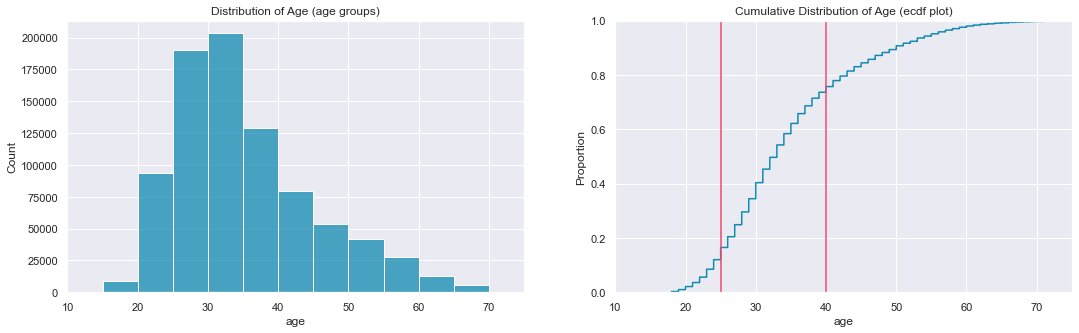

In [40]:
# Plotting the distribution of age groups after some fine-tuning:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

ax1.set_title('Distribution of Age (age groups)')
start, stop, step = 10, 70, 5 
bin_edges = np.arange(start, stop+step, step)
ax1.set_xlim(start, stop+step) # Limits are based on summary stats
sns.histplot(data=df, x='age', stat='count', bins=bin_edges, color=blue, ax=ax1)

ax2.set_title('Cumulative Distribution of Age (ecdf plot)')
ax2.set_xlim(start, stop+step) # Limits are based on summary stats
sns.ecdfplot(data=df, x='age', stat='proportion', color=blue, ax=ax2)
ax2.axvline(25, color=red)
ax2.axvline(40, color=red);

> - It may be useful to plot age in groups if we are seeking some preliminary information to guide, for instance, an advertising campaign.
> - Most bike rides were done by age groups 30-35 > 25-30 > 35-40.
> - About 60% of bike rides were done by people aged around 25-40 years.

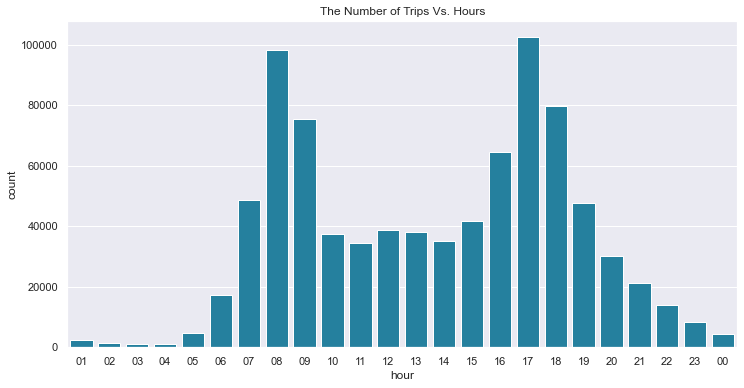

In [41]:
# Plotting trip counts Vs. hours:
plt.figure(figsize=(12, 6))
plt.title('The Number of Trips Vs. Hours')
g = sns.countplot(data=df, x='hour', color=blue);

> - The distribution here is bimodal, suggesting  2 rush hours: 7am : 9am & 4pm : 7pm.
> - The rides reach their nadir between 1-4 am.

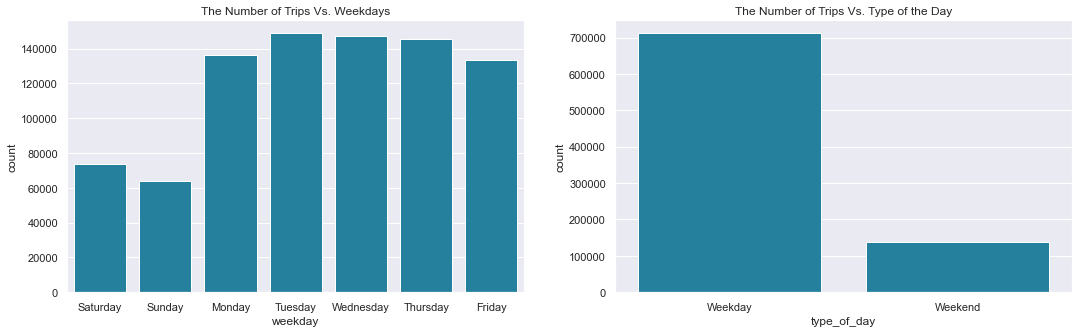

In [42]:
# Plotting trip counts Vs.weekdays and the type of the day:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

ax1.set_title('The Number of Trips Vs. Weekdays')
sns.countplot(data=df, x='weekday', color=blue, ax=ax1)

ax2.set_title('The Number of Trips Vs. Type of the Day')
sns.countplot(data=df, x='type_of_day', color=blue, ax=ax2);

> - Another common pattern is that weekdays tend to witness more rides than weekends.

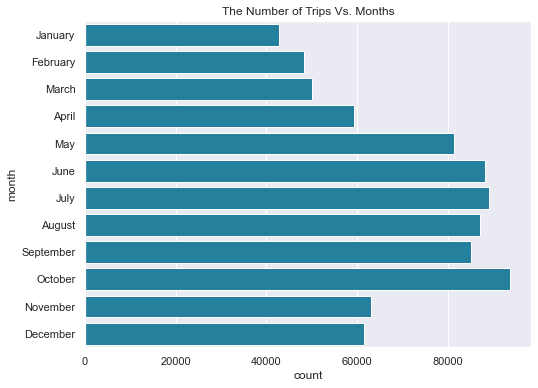

In [43]:
# Plotting trip counts Vs. months:
plt.figure(figsize=(8, 6))
plt.title('The Number of Trips Vs. Months')
g = sns.countplot(data=df, y='month', color=blue);

> - Again there is a common pattern, winter months witness less rides.

In [44]:
df['duration_min'].describe([0.99])

count    849069.000000
mean         11.952883
std          31.008806
min           1.000000
50%           9.000000
99%          54.000000
max        1438.000000
Name: duration_min, dtype: float64

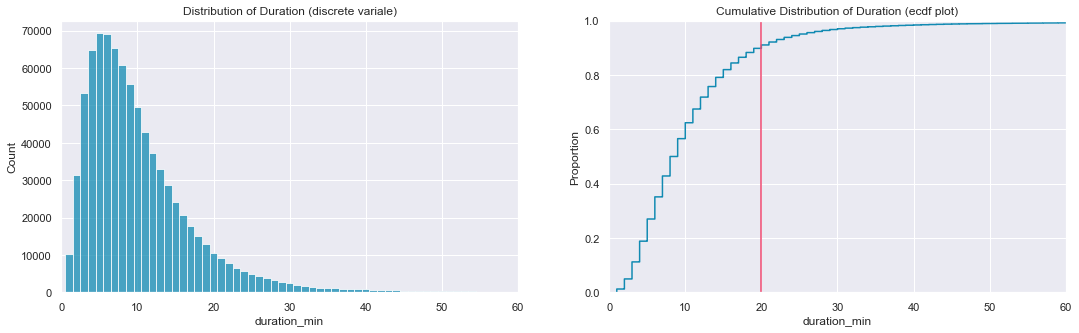

In [45]:
# Plotting the distribution of duration (discrete variable - cumulative frequency):
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

ax1.set_title('Distribution of Duration (discrete variale)')
ax1.set_xlim(0, 60) # Limits are based on summary stats
sns.histplot(data=df, x='duration_min', stat='count', discrete=True, color=blue, ax=ax1)

ax2.set_title('Cumulative Distribution of Duration (ecdf plot)')
ax2.set_xlim(0, 60) # Limits are based on summary stats
sns.ecdfplot(data=df, x='duration_min', stat='proportion', color=blue, ax=ax2)
ax2.axvline(20, color=red);

> - The distribution is skewed to the right suggesting that long rides are less common.
> - About 90% of the rides took less than 20 minutes.

In [46]:
df['distance_m'].describe([0.99])

count    849069.000000
mean       1634.990532
std        1002.220919
min          13.000000
50%        1401.000000
99%        4782.000000
max       65308.000000
Name: distance_m, dtype: float64

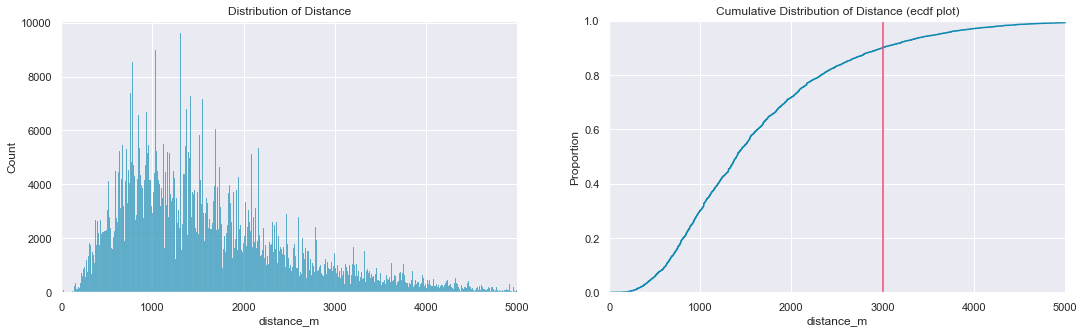

In [47]:
# Plotting the distribution of distance:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

start, stop, step = 0, 5000, 10
bin_edges = np.arange(start, stop+step, step)
ax1.set_title('Distribution of Distance')
ax1.set_xlim(start, stop+step)
sns.histplot(data=df, x='distance_m', stat='count', bins=bin_edges, color=blue, ax=ax1)

ax2.set_title('Cumulative Distribution of Distance (ecdf plot)')
ax2.set_xlim(start, stop+step)
sns.ecdfplot(data=df, x='distance_m', stat='proportion', color=blue, ax=ax2)
ax2.axvline(3000, color=red);

> - The distribution is skewed to the right suggesting that long rides are less common.
> - About 90% of the rides are less than 3 km long.
> - There are some spikes.

In [48]:
# Filtering the top 20 start stations:
top_20_strt_st = df['start_station_name'].value_counts().head(20).index.to_list()
df_ = df.query("start_station_name in @top_20_strt_st")

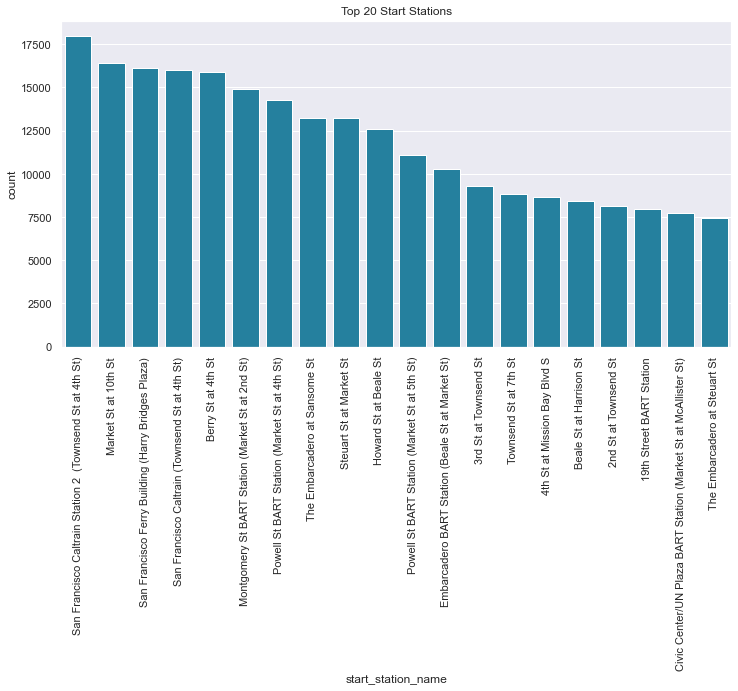

In [49]:
# Plotting the frequency of top 20 start stations:
plt.figure(figsize=(12, 6))
plt.title('Top 20 Start Stations')
plt.xticks(rotation=90)
g = sns.countplot(data=df_, x='start_station_name', color=blue, order=top_20_strt_st);

> - Here are the top 20 start stations.

In [50]:
# Filtering the top 20 end stations:
top_20_end_st = df['end_station_name'].value_counts().head(20).index.to_list()
df_ = df.query("end_station_name in @top_20_end_st")

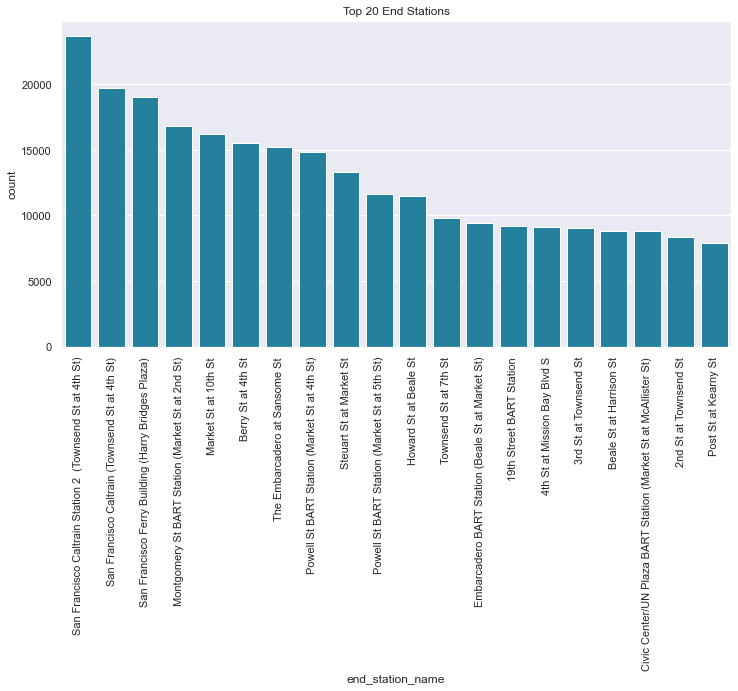

In [51]:
# Plotting the frequency of top 20 end stations:
plt.figure(figsize=(12, 6))
plt.title('Top 20 End Stations')
plt.xticks(rotation=90)
g = sns.countplot(data=df_, x='end_station_name', color=blue, order=top_20_end_st);

> - Here are the top 20 end stations.

In [52]:
# Are there any common stations in the top 20's?
top_20_strt_st = set(top_20_strt_st)
top_20_end_st = set(top_20_end_st)

common_top_20 = top_20_strt_st.intersection(top_20_end_st)
len(common_top_20)

19

> - There is 19 out of the 20 top stations are common between the 2 groups which may make sense.
> - This finding may guide our analysis to avoid counting the same route twice (when determining the most common routes).

In [53]:
# Filtering the top 20 trips:
top_20_trips = df['trip'].value_counts().head(20).index.to_list()
df_ = df.query("trip in @top_20_trips")

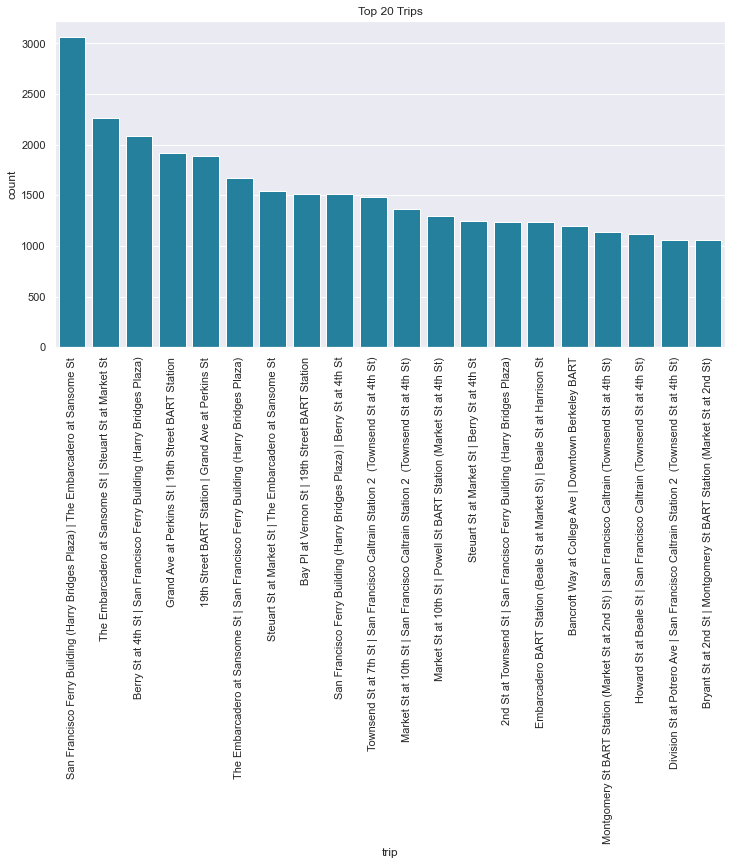

In [54]:
# Plotting the top 20 trips:
plt.figure(figsize=(12, 6))
plt.title('Top 20 Trips')
plt.xticks(rotation=90)
g = sns.countplot(data=df_, x='trip', color=blue, order=top_20_trips);

> - Route #1 and route #6 are the same.
> - Route #2 and route #7 are the same.
> - Route #3 and route #9 are the same.
> - Route #4 and route #5 are the same.
> - This suggests that we may want to find another way to avoid overcounting.

In [55]:
# Creating a matrix for start stations vs end stations:
strt_end_st_trip_counts = df.pivot_table(index='start_station_name', columns='end_station_name',
                                         values='user_type', aggfunc='count', fill_value=0)

> - First, we create a matrix for start stations as index, end stations as columsn and counts as values.

In [56]:
# Defining a function to count each trip using the matrix:
def avoid_duplicates(trip):
    
    """
    This function searches for trip counts in both directions start >> end and end >> start.
    
    Args:
    (str): The trip.
    
    Returns:
    (int): The corrected count.
    """
    
    st_1, st_2 = trip.split(' | ')
    return strt_end_st_trip_counts.loc[st_1, st_2] + strt_end_st_trip_counts.loc[st_2, st_2]

> - Then we define a function to count trips for the same route in both directions.

In [57]:
# Creating a dataframe with a single column (trips):
top_trips = pd.DataFrame(df['trip'].value_counts(ascending=False).head(50).index.to_list())
top_trips.rename(columns=lambda x: 'trip', inplace=True)

In [58]:
# Populating the dataframe with a second column for the count of each trip:
top_trips['counts'] = top_trips['trip'].apply(avoid_duplicates)

In [59]:
# Dropping duplicated trips:
top_trips.drop_duplicates(subset='counts', inplace=True)
top_trips.sort_values(by='counts', ascending=False, inplace=True)

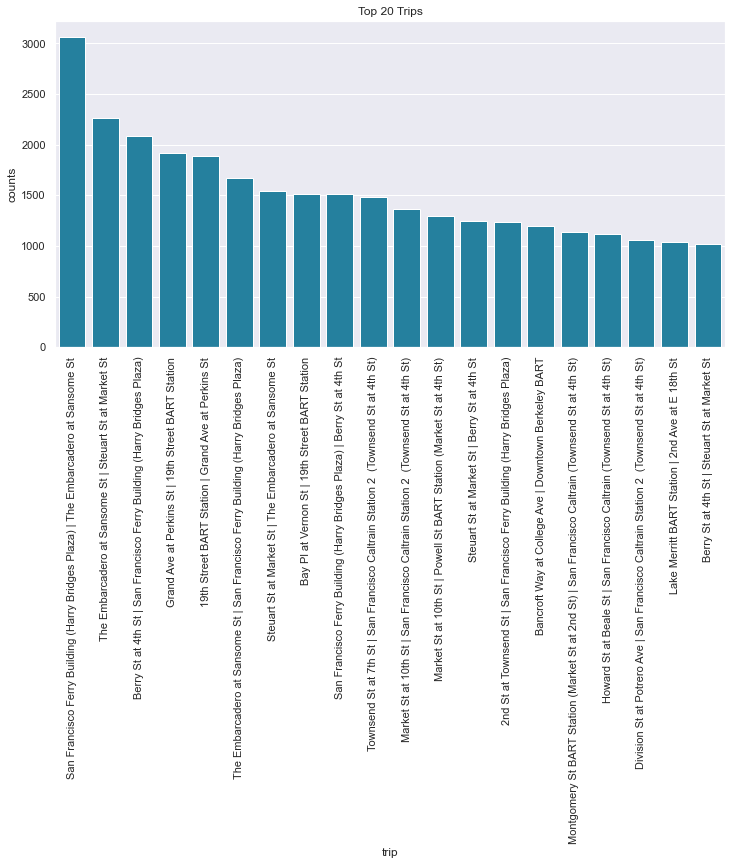

In [60]:
# Plotting the top 20 trips:
plt.figure(figsize=(12, 6))
plt.title('Top 20 Trips')
plt.xticks(rotation=90)
g = sns.barplot(data=top_trips.head(20), x='trip', y='counts', color=blue);

> - Voila! No duplicated routes.

### Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

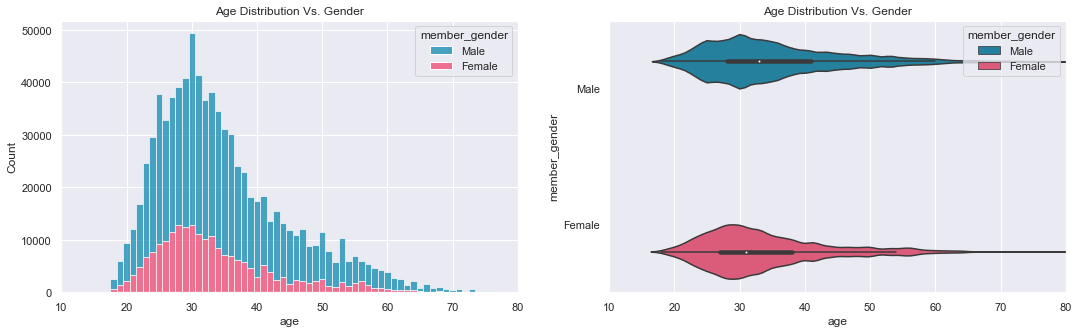

In [61]:
# Plotting the distribution of age Vs. gender:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

ax1.set_title('Age Distribution Vs. Gender')
ax1.set_xlim(10, 80)
sns.histplot(data=df, x='age', stat='count', discrete=True, hue='member_gender', multiple='stack',
             hue_order=['Male', 'Female'], palette={'Male': blue, 'Female': red}, ax=ax1)

ax2.set_title('Age Distribution Vs. Gender')
ax2.set_xlim(10, 80)
sns.violinplot(data=df, x='age', y='member_gender', order=['Male', 'Female'], hue='member_gender',
               hue_order=['Male', 'Female'], palette={'Male': blue, 'Female': red}, ax=ax2);

> - It turns out that the distribution of both genders is nearly the same.
> - However, the IQR of males is slightly shifted to the right.

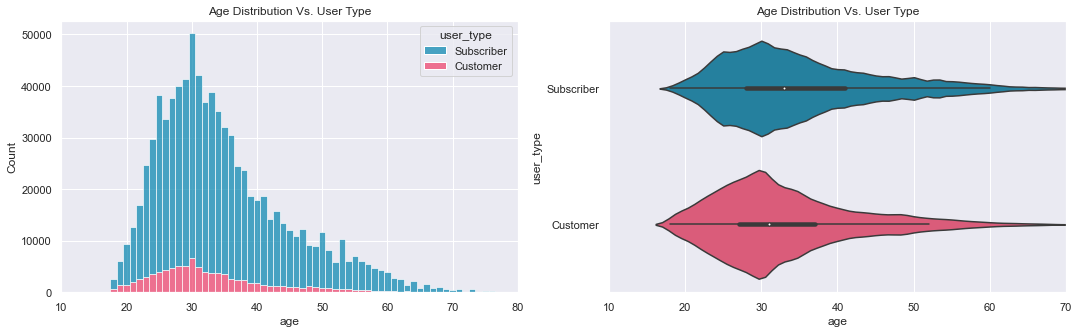

In [62]:
# Plotting the distribution of age Vs. user type:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

ax1.set_title('Age Distribution Vs. User Type')
ax1.set_xlim(10, 80)
sns.histplot(data=df, x='age', stat='count', discrete=True, hue='user_type', multiple='stack',
             hue_order=['Subscriber', 'Customer'], palette={'Subscriber': blue, 'Customer': red}, ax=ax1)

ax2.set_title('Age Distribution Vs. User Type')
ax2.set_xlim(10, 70)
sns.violinplot(data=df, x='age', y='user_type', order=['Subscriber', 'Customer'],
              palette={'Subscriber': blue, 'Customer': red}, ax=ax2);

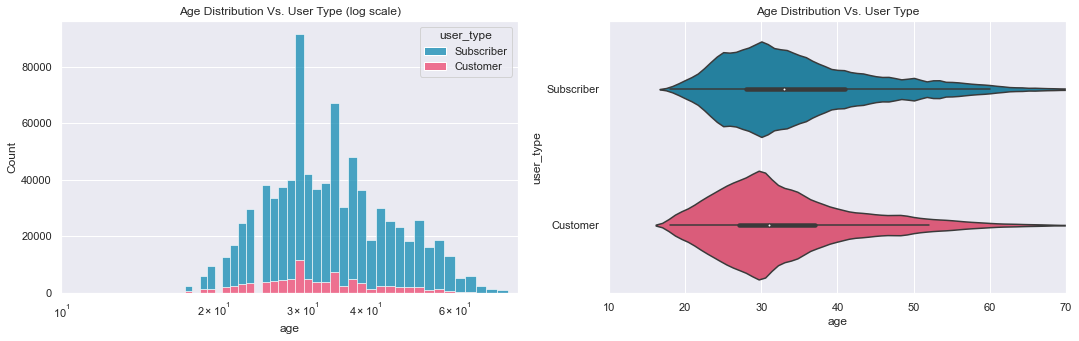

In [63]:
# Plotting the distribution of age Vs. user type:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

bin_edges = 10**np.arange(0, 2, 0.005)
ax1.set_title('Age Distribution Vs. User Type (log scale)')
ax1.set_xlim(10, 80)
sns.histplot(data=df, x='age', stat='count', bins=bin_edges,log_scale=True , hue='user_type', multiple='stack',
             hue_order=['Subscriber', 'Customer'], palette={'Subscriber': blue, 'Customer': red}, ax=ax1)

ax2.set_title('Age Distribution Vs. User Type')
ax2.set_xlim(10, 70)
sns.violinplot(data=df, x='age', y='user_type', order=['Subscriber', 'Customer'],
              palette={'Subscriber': blue, 'Customer': red}, ax=ax2);

> - The same plot after transforming the x-axis into log scale.

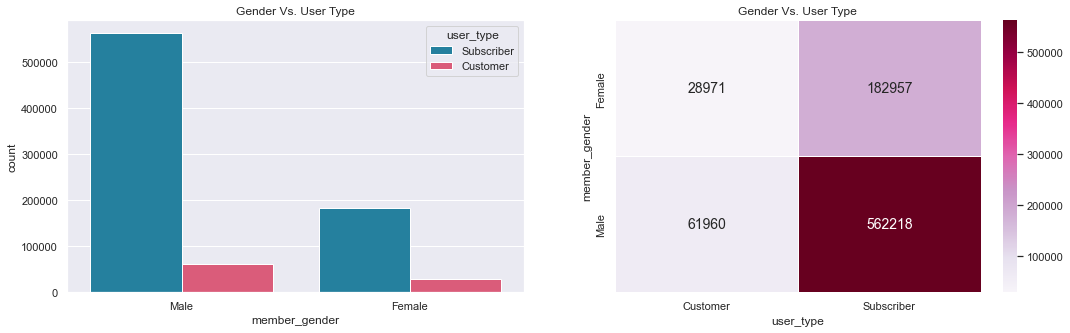

In [64]:
# Plotting the counts of gender Vs. user type:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

ax1.set_title('Gender Vs. User Type')
sns.countplot(data=df, x='member_gender', order=['Male', 'Female'],
              hue='user_type', palette={'Subscriber': blue, 'Customer': red}, ax=ax1)

gen_vs_user_type_counts = df.pivot_table(index='member_gender', columns='user_type',values='start_station_name',
                                         aggfunc='count', fill_value=0).query("member_gender in ['Male', 'Female']")

ax2.set_title('Gender Vs. User Type')
sns.heatmap(data=gen_vs_user_type_counts, cmap='PuRd', linewidth=1, annot=True,
            fmt='.0f', annot_kws={'fontsize': 14}, ax=ax2);

In [65]:
male_cr = (df.query("member_gender == 'Male'")['user_type'] == 'Subscriber').mean()
female_cr = (df.query("member_gender == 'Female'")['user_type'] == 'Subscriber').mean()
male_cr, female_cr

(0.9007334446263726, 0.8632979124985845)

> - It seems that given a user being male has a slightly higher chance to convert than being a female.

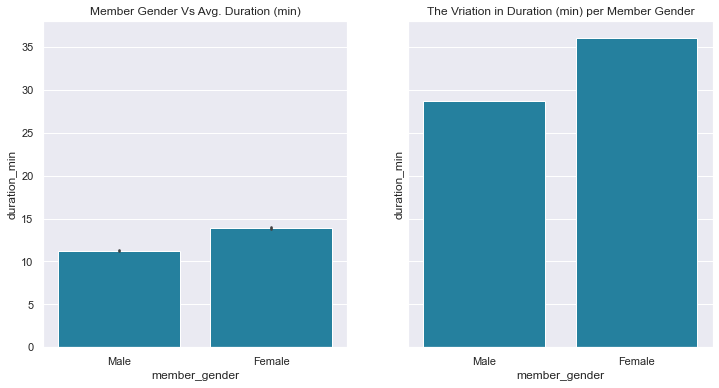

In [66]:
# Plotting gender Vs. average trip durartion:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))

ax1.set_title('Member Gender Vs Avg. Duration (min)')
sns.barplot(data=df, x='member_gender', y='duration_min', order=['Male', 'Female'], color=blue, ax=ax1)

ax2.set_title('The Vriation in Duration (min) per Member Gender')
sns.barplot(data=df, x='member_gender', y='duration_min', order=['Male', 'Female'], estimator=np.std, ci=False, color=blue, ax=ax2);

> - Females may rider for slightly longer durations with higher variation than males.

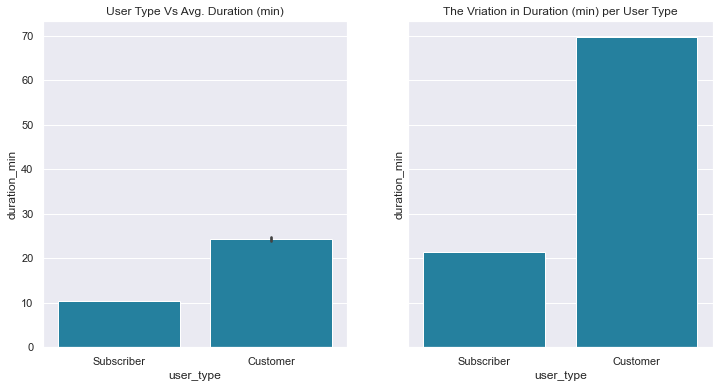

In [67]:
# Plotting user type Vs. average trip durartion:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))

ax1.set_title('User Type Vs Avg. Duration (min)')
sns.barplot(data=df, x='user_type', y='duration_min', color=blue, ax=ax1)

ax2.set_title('The Vriation in Duration (min) per User Type')
sns.barplot(data=df, x='user_type', y='duration_min', estimator=np.std, ci=False, color=blue, ax=ax2);

> - It turns out that subcribers are more like to ride for a fixed duration (they may use the service for fixed trips) than customers.

In [68]:
df[['age', 'duration_min']].describe([0.99]).T

,count,mean,std,min,50%,99%,max
age,849069.0,34.871589,10.209165,18.0,33.0,64.0,98.0
duration_min,849069.0,11.952883,31.008806,1.0,9.0,54.0,1438.0


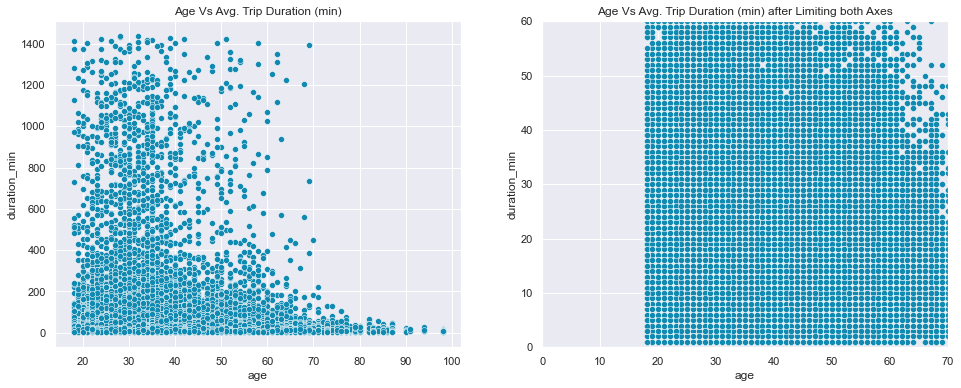

In [69]:
# Plotting age Vs. trip duration:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.set_title('Age Vs Avg. Trip Duration (min)')
sns.scatterplot(data=df, x='age', y='duration_min', estimator=np.mean, color=blue, ax=ax1);

ax2.set_xlim(0, 70) # Limits were chosen ased on univariate plotting
ax2.set_ylim(0, 60) # Limits were chosen ased on univariate plotting
ax2.set_title('Age Vs Avg. Trip Duration (min) after Limiting both Axes')
sns.scatterplot(data=df, x='age', y='duration_min', estimator=np.mean, color=blue, ax=ax2);

<AxesSubplot:title={'center':'Distribution of Trip Duration (min) among different Age Groups'}, xlabel='age_group', ylabel='duration_min'>

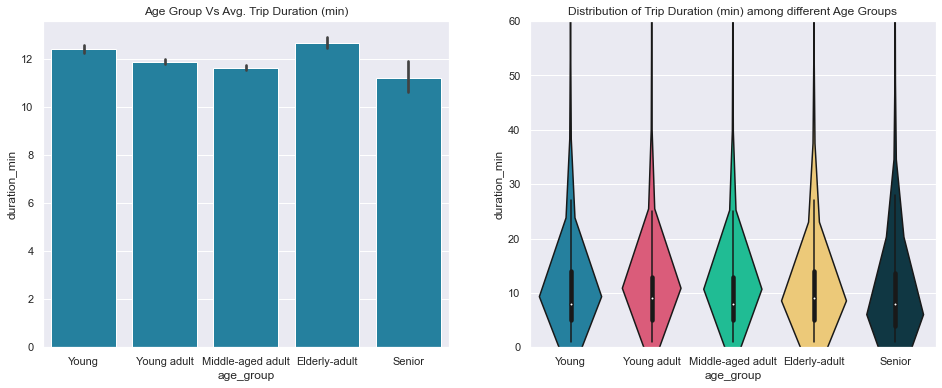

In [70]:
# Plotting age groups Vs. trip duration:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.set_title('Age Group Vs Avg. Trip Duration (min)')
sns.barplot(data=df, x='age_group', y='duration_min', color=blue, ax=ax1)

ax2.set_ylim(0, 60) # Limits are based on univariate plotting
ax2.set_title('Distribution of Trip Duration (min) among different Age Groups')
sns.violinplot(data=df, x='age_group', y='duration_min', ax=ax2)

> - There is no correlation between age and trip duration.
> - The trip average duration and distribution is nearly the same among all age groups.
> - There is a slight relatively higher variation in trip duration within the seniors group.

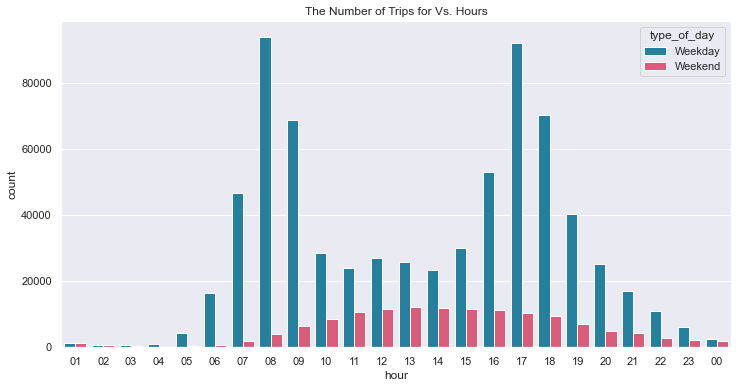

In [71]:
# Plotting the trip counts Vs. hours Vs. the type of the day:
plt.figure(figsize=(12, 6))
g = sns.countplot(data=df, x='hour', hue='type_of_day')
g.set(title='The Number of Trips for Vs. Hours');

> - This is interesting! It seems that during weekdays the majority of rides are more likely to be during rush hours (riders may use the srvice for fixed trips), on the other hand the majority of rides in weekends are more likely to be during the period 7 am - 10 pm.

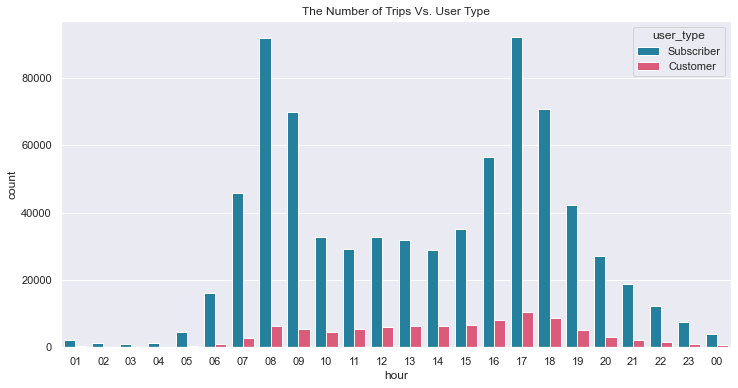

In [72]:
# Plotting the trip counts Vs. hours Vs. the user type:
plt.figure(figsize=(12, 6))
g = sns.countplot(data=df, x='hour', hue='user_type')
g.set(title='The Number of Trips Vs. User Type');

> - Again this is interesting! It seems that subscribers are more likely to ride during rush hours (they may use the srvice for fixed trips as formerly mentioned), on the other hand customer are more to ride 7 am - 8 pm.

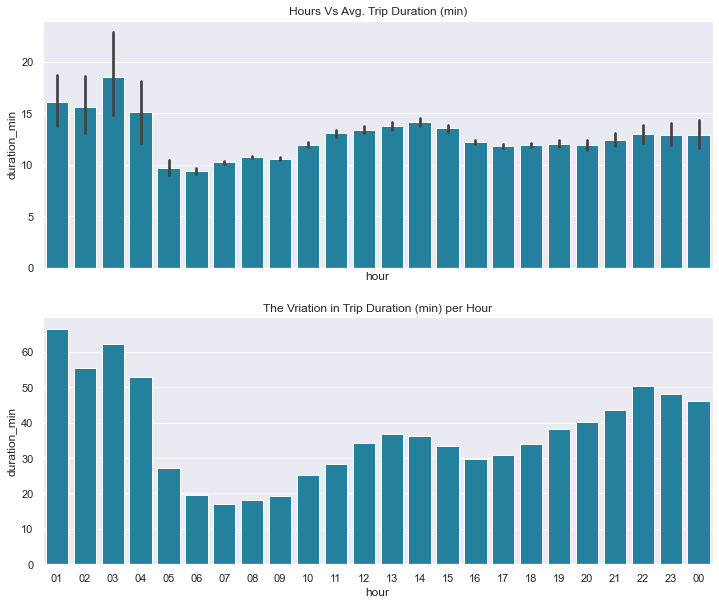

In [73]:
# Plotting hours Vs. average trip duration:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12, 10))
ax1, ax2 = axs.flatten()

ax1.set_title('Hours Vs Avg. Trip Duration (min)')
sns.barplot(data=df, x='hour', y='duration_min', color=blue, ax=ax1)

ax2.set_title('The Vriation in Trip Duration (min) per Hour')
sns.barplot(data=df, x='hour', y='duration_min', estimator=np.std, ci=False, color=blue, ax=ax2);

> - During rush hours, the average trip duration is nearly the same with minimal variation.
> - During the rest of the day, there is a relatively higher variation in trip duration.

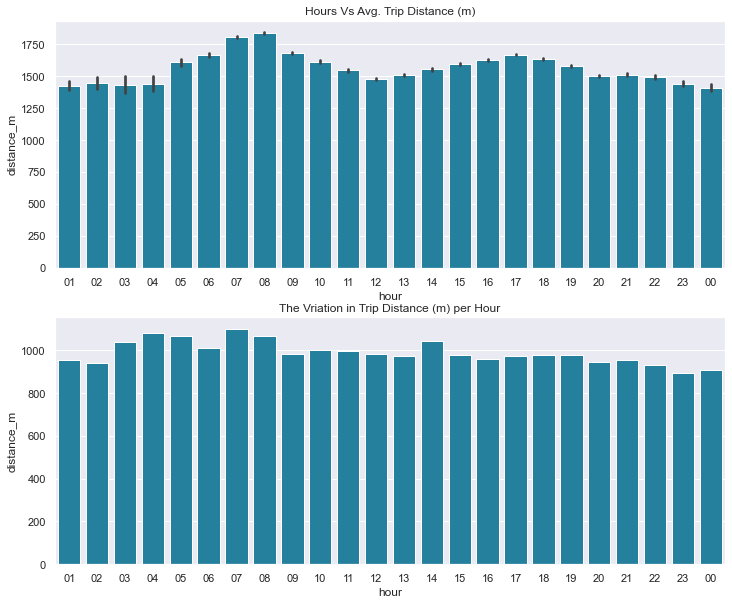

In [74]:
# Plotting hours Vs. average trip distance:
fig, axs = plt.subplots(2, 1, figsize=(12, 10))
ax1, ax2 = axs.flatten()

ax1.set_title('Hours Vs Avg. Trip Distance (m)')
sns.barplot(data=df, x='hour', y='distance_m', color=blue, ax=ax1)

ax2.set_title('The Vriation in Trip Distance (m) per Hour')
sns.barplot(data=df, x='hour', y='distance_m', estimator=np.std, ci=False, color=blue, ax=ax2);

> - The results are relatively consistent with the formerly mentioned rush hours.
> - there is a relatively higher variation in trip duration away from rush hours.

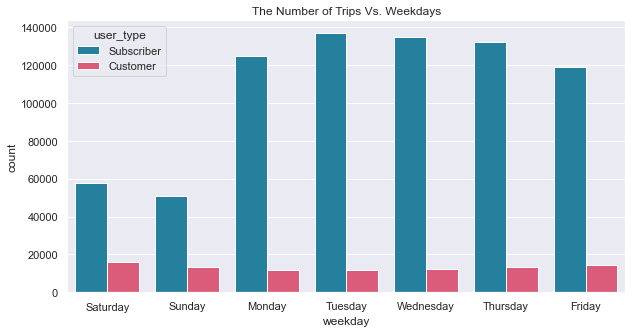

In [75]:
# Plotting the trip counts Vs. weekdays Vs. the type of day:
plt.figure(figsize=(10, 5))
g = sns.countplot(data=df, x='weekday', hue='user_type')
g.set(title='The Number of Trips Vs. Weekdays');

> - The activity differs according to the type of the day, subscribers dominate weekdays, while customers dominate weekends.

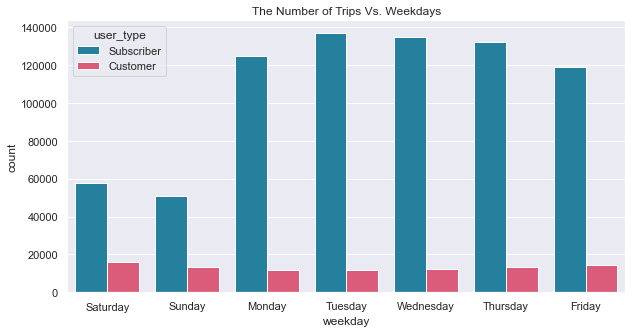

In [76]:
# Plotting the trip counts Vs. weekdays Vs. the user type:
plt.figure(figsize=(10, 5))
g = sns.countplot(data=df, x='weekday', hue='user_type')
g.set(title='The Number of Trips Vs. Weekdays');

> - The pattern of subscribers activity foolows that of rush hours.
> - The customers activity is relatively the same across all weekdays.

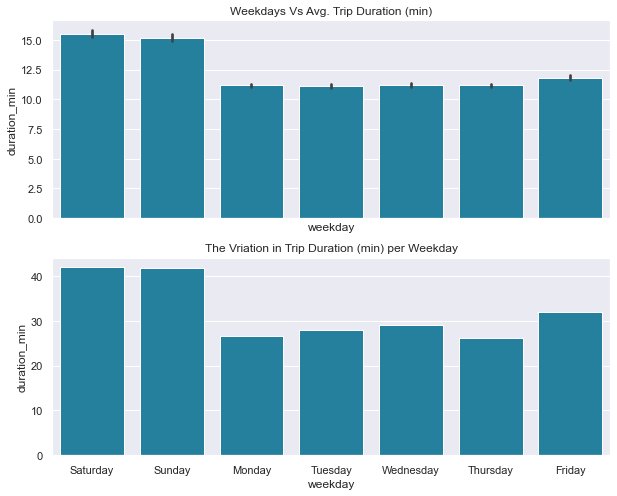

In [77]:
# Plotting weekdays Vs average trip duration:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

ax1.set_title('Weekdays Vs Avg. Trip Duration (min)')
sns.barplot(data=df, x='weekday', y='duration_min', color=blue, ax=ax1)

ax2.set_title('The Vriation in Trip Duration (min) per Weekday')
sns.barplot(data=df, x='weekday', y='duration_min', estimator=np.std, ci=False, color=blue, ax=ax2);

> - Trip duration tend to be slightly longer and more variale in weekends (Fri evening - Sat - Sun).

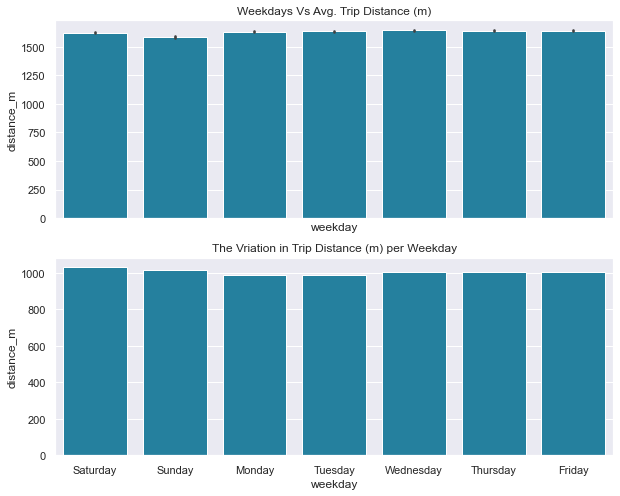

In [78]:
# Plotting weekdays Vs average trip distance:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

ax1.set_title('Weekdays Vs Avg. Trip Distance (m)')
sns.barplot(data=df, x='weekday', y='distance_m', color=blue, ax=ax1)

ax2.set_title('The Vriation in Trip Distance (m) per Weekday')
sns.barplot(data=df, x='weekday', y='distance_m', estimator=np.std, ci=False, color=blue, ax=ax2);

> - There is no obvious pattern here.

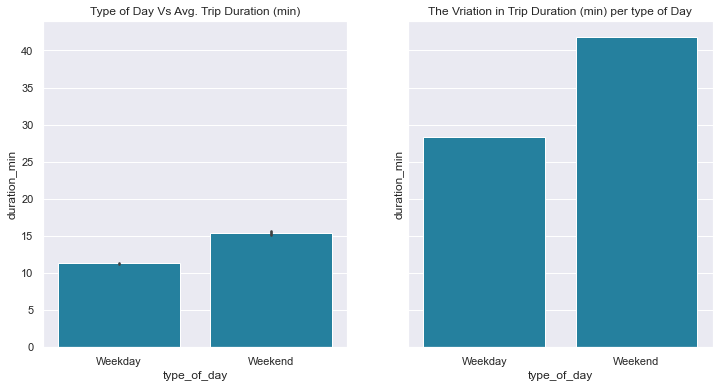

In [79]:
# Plotting the type of day Vs average trip duration:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))

ax1.set_title('Type of Day Vs Avg. Trip Duration (min)')
sns.barplot(data=df, x='type_of_day', y='duration_min', color=blue, ax=ax1)

ax2.set_title('The Vriation in Trip Duration (min) per type of Day')
sns.barplot(data=df, x='type_of_day', y='duration_min', estimator=np.std, ci=False, color=blue, ax=ax2);

> - longer and relatively more variable rides are more likely to occur during weeekends than weekdays.

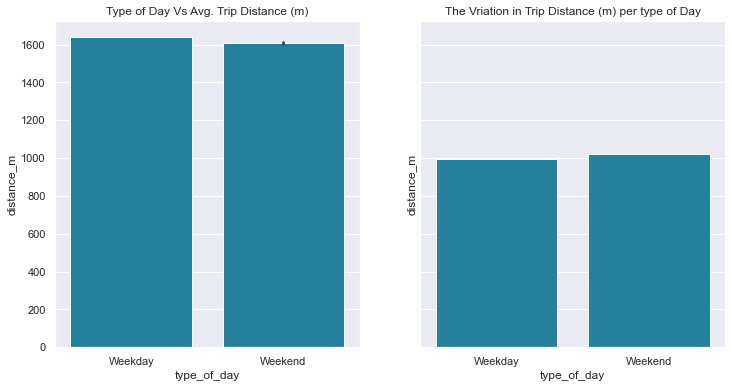

In [80]:
# Plotting the type of day Vs average trip distance:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))

ax1.set_title('Type of Day Vs Avg. Trip Distance (m)')
sns.barplot(data=df, x='type_of_day', y='distance_m', color=blue, ax=ax1)

ax2.set_title('The Vriation in Trip Distance (m) per type of Day')
sns.barplot(data=df, x='type_of_day', y='distance_m', estimator=np.std, ci=False, color=blue, ax=ax2);

> - There is no obvious pattern here.

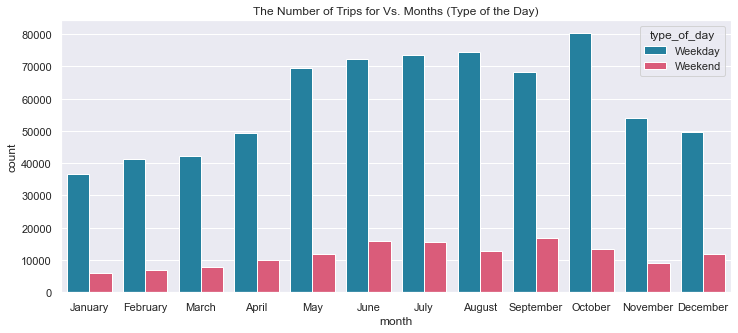

In [81]:
# Plotting the frequency of months according to the type of day:
plt.figure(figsize=(12, 5))
g = sns.countplot(data=df, x='month', hue='type_of_day')
g.set(title='The Number of Trips for Vs. Months (Type of the Day)');

> - The winter months witness less rides, other than that there is no obviuos pattern here.

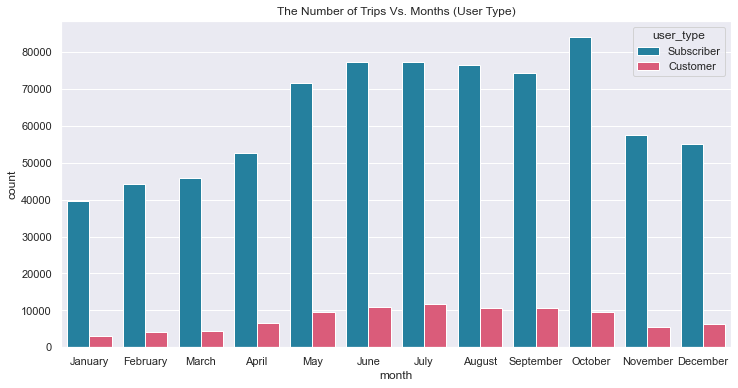

In [82]:
# Plotting the frequency of months according to the user type:
plt.figure(figsize=(12, 6))
g = sns.countplot(data=df, x='month', hue='user_type')
g.set(title='The Number of Trips Vs. Months (User Type)');

> - The winter months witness less rides, other than that there is no obviuos pattern here.

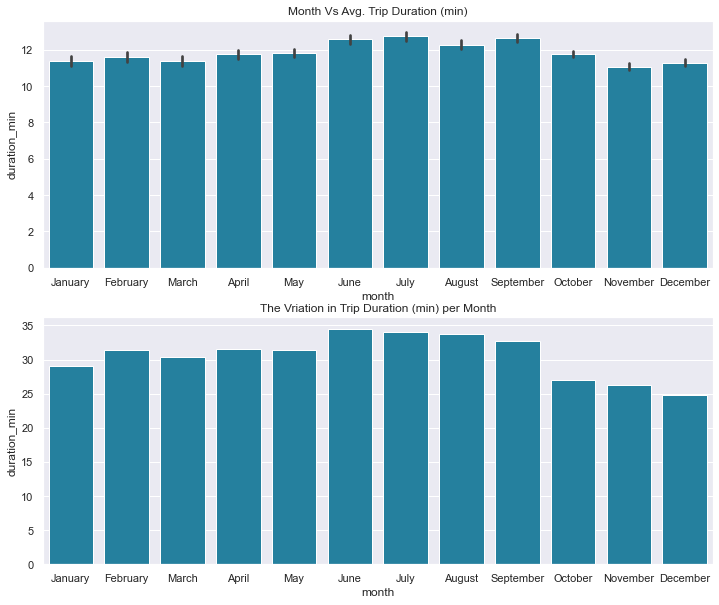

In [83]:
# Plotting the month Vs average trip duration:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

ax1.set_title('Month Vs Avg. Trip Duration (min)')
sns.barplot(data=df, x='month', y='duration_min', color=blue, ax=ax1)

ax2.set_title('The Vriation in Trip Duration (min) per Month')
sns.barplot(data=df, x='month', y='duration_min', estimator=np.std, ci=False, color=blue, ax=ax2);

> - Winter months witness slightly shorter rides.

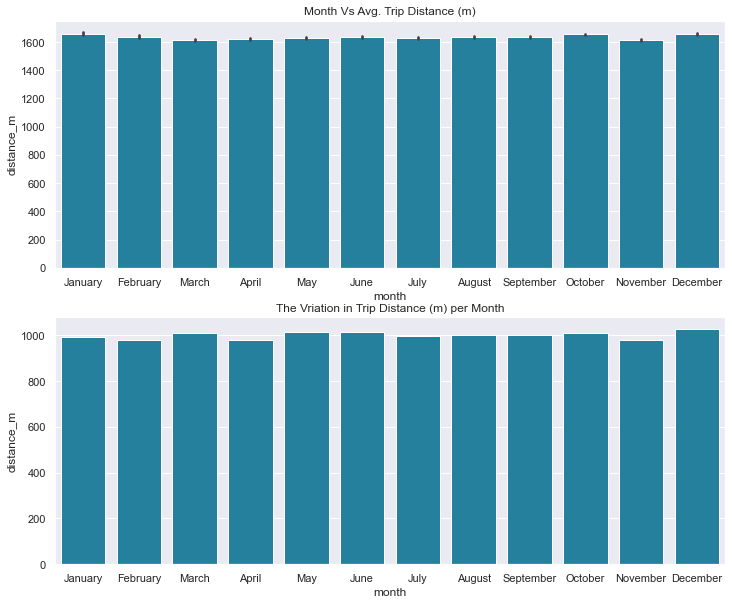

In [84]:
# Plotting the month Vs average trip distance:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

ax1.set_title('Month Vs Avg. Trip Distance (m)')
sns.barplot(data=df, x='month', y='distance_m', color=blue, ax=ax1)

ax2.set_title('The Vriation in Trip Distance (m) per Month')
sns.barplot(data=df, x='month', y='distance_m', estimator=np.std, ci=False, color=blue, ax=ax2);

> - There is no obvious pattern here.

In [85]:
df[['duration_min', 'distance_m']].describe([0.99]).T

,count,mean,std,min,50%,99%,max
duration_min,849069.0,11.952883,31.008806,1.0,9.0,54.0,1438.0
distance_m,849069.0,1634.990532,1002.220919,13.0,1401.0,4782.0,65308.0


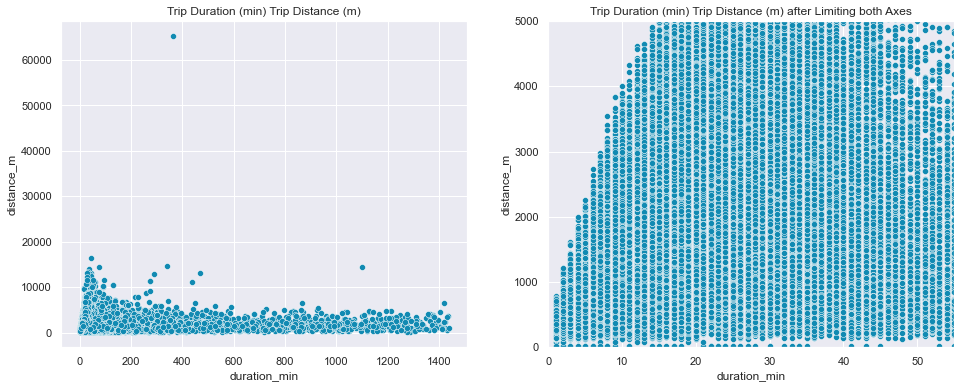

In [86]:
# Plotting trip duration Vs distance:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.set_title('Trip Duration (min) Trip Distance (m)')
sns.scatterplot(data=df, x='duration_min', y='distance_m', estimator=np.mean, color=blue, ax=ax1);

ax2.set_xlim(0, 55) # Limits were chosen ased on summary stats
ax2.set_ylim(0, 5000) # Limits were chosen ased on summary stats
ax2.set_title('Trip Duration (min) Trip Distance (m) after Limiting both Axes')
sns.scatterplot(data=df, x='duration_min', y='distance_m', estimator=np.mean, color=blue, ax=ax2);

> - There is no correltion between duration and distance which is somewhat unexpected!

In [87]:
# Creating a pivot table for hours Vs weekday:
hrs_vs_wkdays_trip_counts = df.pivot_table(index='hour', columns='weekday', values='start_station_name',
                                           aggfunc='count', fill_value=0)[weekdays]

hrs_vs_wkdays_trip_counts.index = hrs_vs_wkdays_trip_counts.index.astype(hours_cat)
hrs_vs_wkdays_trip_counts.sort_index(inplace=True)

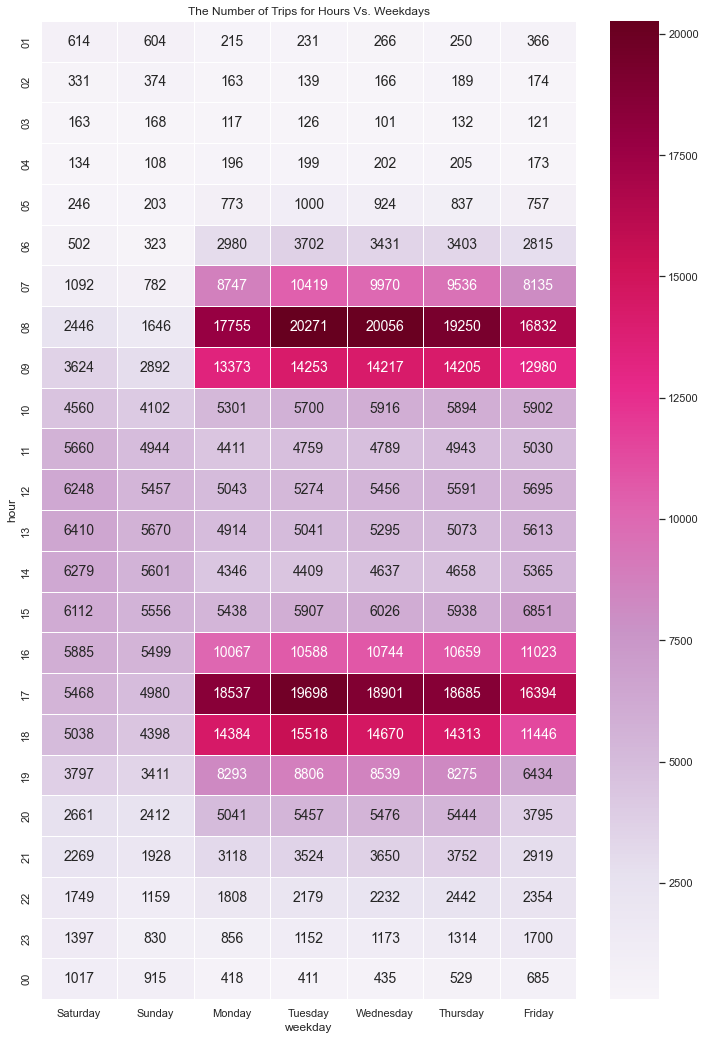

In [88]:
# Plotting a heatmap for hours Vs weekday:
plt.figure(figsize=(12, 18))
g = sns.heatmap(data=hrs_vs_wkdays_trip_counts, cmap='PuRd', linewidth=1,
                annot=True, fmt='.0f', annot_kws={'fontsize': 14})
g.set(title='The Number of Trips for Hours Vs. Weekdays');

> - Another clue for the fact that the majority of rides are more likely to be during rush hours (the 2 peaks of the trip counts Vs hours countplot) in weekdays.

In [89]:
# Creating a pivot table for months Vs weekday:
months_vs_wkdays_trip_counts = df.pivot_table(index='month', columns='weekday',
                                              values='user_type', aggfunc='count', fill_value=0)[weekdays]

months_vs_wkdays_trip_counts.index = months_vs_wkdays_trip_counts.index.astype(months_cat)

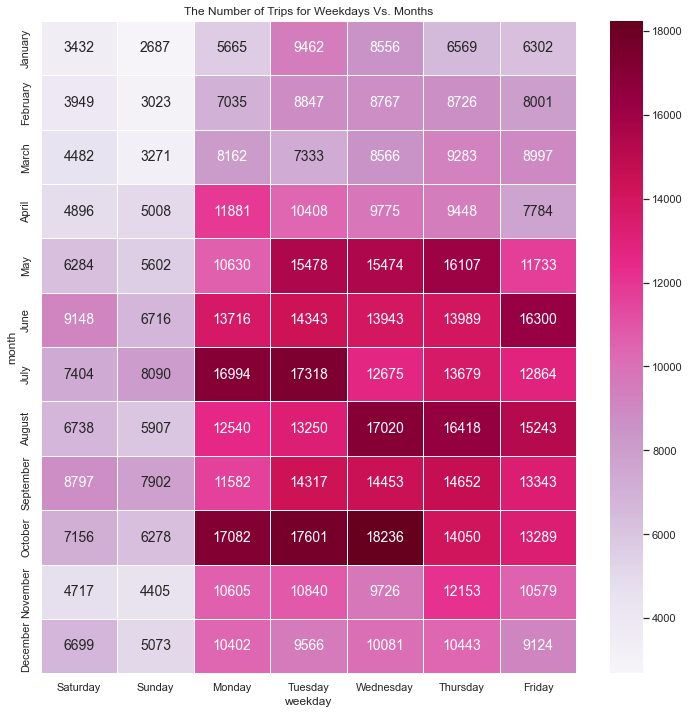

In [90]:
# Plotting a heatmap for for months Vs. weekday:
plt.figure(figsize=(12, 12))
g = sns.heatmap(data=months_vs_wkdays_trip_counts, cmap='PuRd', linewidth=1,
                annot=True, fmt='.0f', annot_kws={'fontsize': 14})
g.set(title='The Number of Trips for Weekdays Vs. Months');

> - The months that witness the leat rides are the winter month.
> - The days that witness the least rides are the weekends.

In [91]:
# Creating a matrix for start stations Vs. end stations:
strt_end_st_trip_counts = df.pivot_table(index='start_station_name', columns='end_station_name',
                                         values='user_type', aggfunc='count', fill_value=0)

# Filtering the dataset:
top_10_strt_st = df['start_station_name'].value_counts().head(10).index.to_list()
top_10_end_st = df['end_station_name'].value_counts().head(10).index.to_list()
matrix_ = strt_end_st_trip_counts.loc[top_10_strt_st, top_10_end_st]

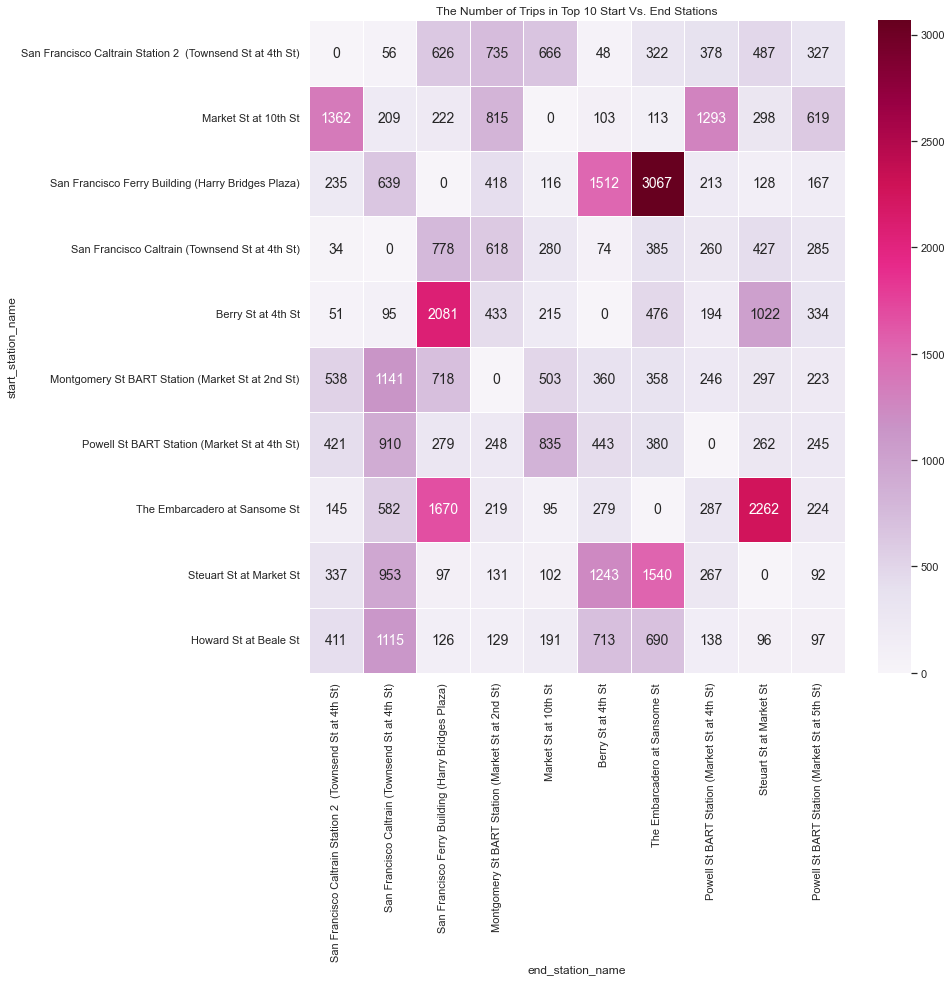

In [92]:
# Plotting a heatmap for trip counts in top 10 start Vs. end stations:
plt.figure(figsize=(12, 12))
g = sns.heatmap(data=matrix_, cmap='PuRd', linewidth=1,
                annot=True, fmt='.0f', annot_kws={'fontsize': 14})
g.set(title='The Number of Trips in Top 10 Start Vs. End Stations');

> - Certain trip are more like to occur more than others (this is consistent with the former findings).

In [93]:
# Creating a matrix for start stations Vs. end stations:
strt_end_st_mean_duration = df.pivot_table(index='start_station_name', columns='end_station_name',
                                           values='duration_min', aggfunc='mean', fill_value=0)

# Filtering the dataset:
matrix_ = strt_end_st_mean_duration.loc[top_10_strt_st, top_10_end_st]

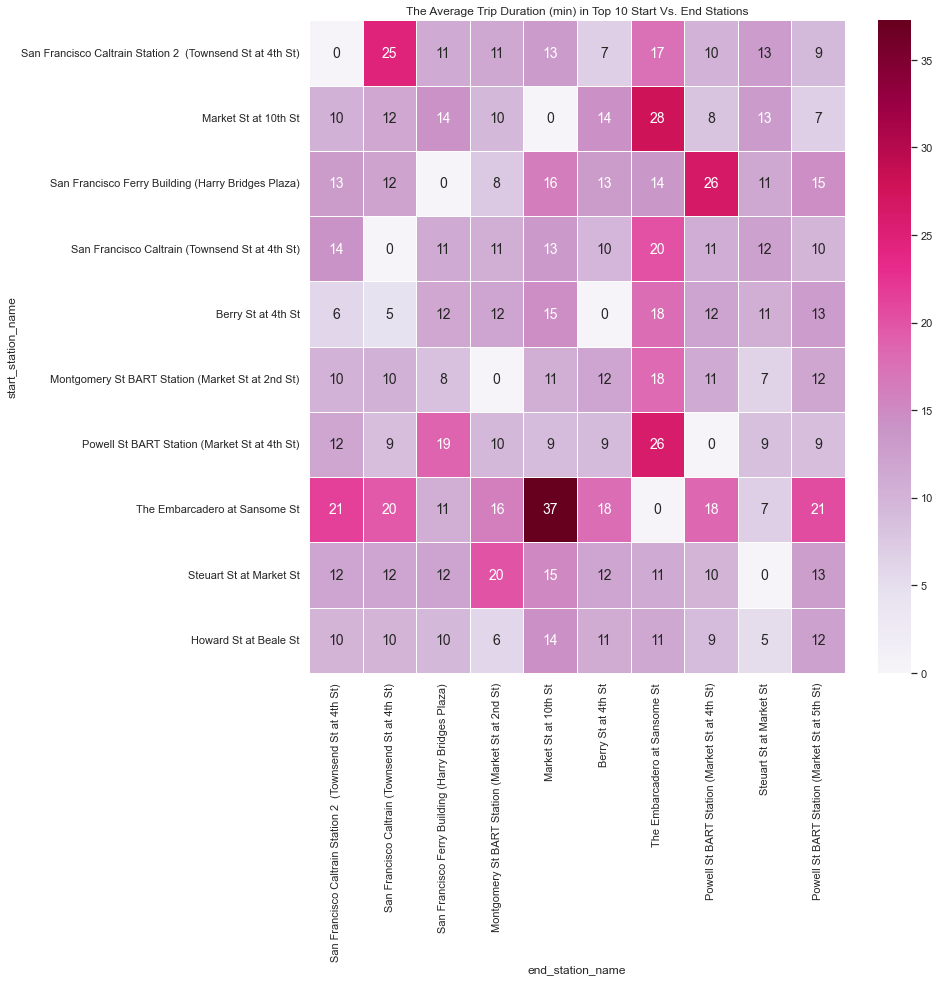

In [94]:
# Plotting a heatmap for the average trip duration in top 10 start Vs. end stations:
plt.figure(figsize=(12, 12))
g = sns.heatmap(data=matrix_, cmap='PuRd', linewidth=1,
                annot=True, fmt='.0f', annot_kws={'fontsize': 14})

g.set(title='The Average Trip Duration (min) in Top 10 Start Vs. End Stations');

> - The average trip duration in top 10 start and end stations is ~= 20 minutes.
> - The maximum trip duration in top 10 start and end stations is 37 mminutes.

### Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

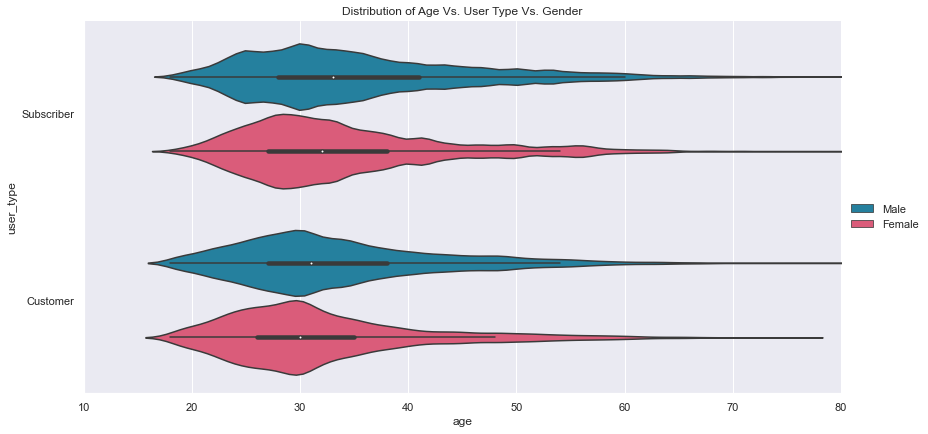

In [95]:
# Plotting the distribution of age Vs. user type Vs. gender (boxplot):
g = sns.FacetGrid(data=df, xlim=(10, 80), height=6, aspect=2)
g.map_dataframe(sns.violinplot, y='user_type', x='age', hue='member_gender',
                palette={'Male': blue, 'Female': red}, hue_order=['Male', 'Female'])

g.set(title='Distribution of Age Vs. User Type Vs. Gender')
g.add_legend();

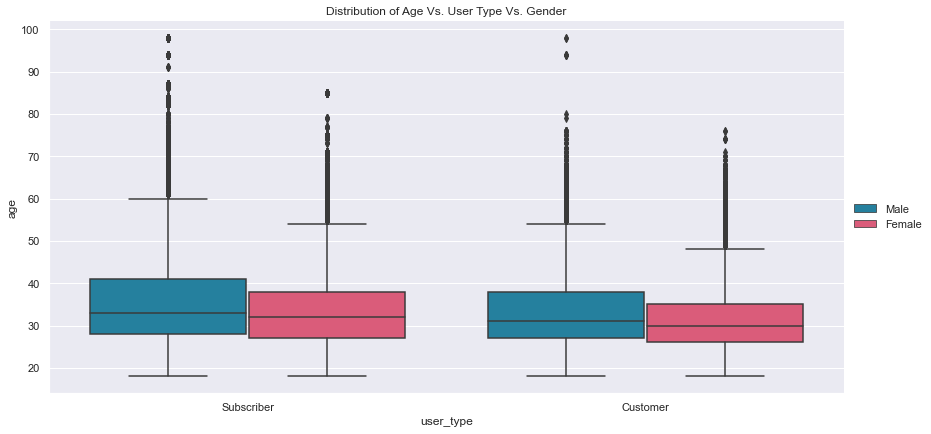

In [96]:
# Plotting the distribution of age Vs. user type Vs. gender (violinplot):
g = sns.FacetGrid(data=df, xlim=(10, 80), height=6, aspect=2)
g.map_dataframe(sns.boxplot, x='user_type', y='age', hue='member_gender',
                palette={'Male': blue, 'Female': red}, hue_order=['Male', 'Female'])

g.set(title='Distribution of Age Vs. User Type Vs. Gender')
g.add_legend();

> - The distribution is nearly the same in both groups.
> - The IQR of males is slighly shifted to the right.
> - The violin plot in the male group has a longer tail (more right-skewed).
> - The age of male subscribers may have 2 modes.

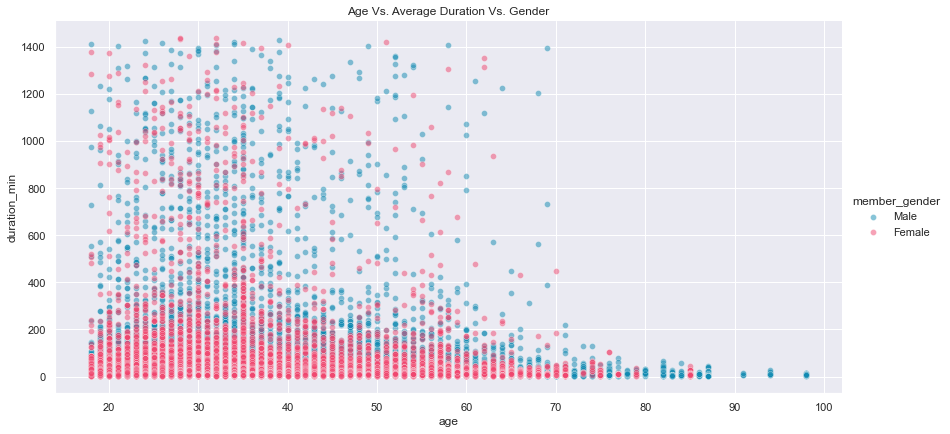

In [97]:
# Plotting age vs average duration Vs. gender (scatterplot):
g = sns.FacetGrid(data=df, hue='member_gender', hue_order=['Male', 'Female'], height=6, aspect=2)
g.map_dataframe(sns.scatterplot, x='age', y='duration_min', estimator=np.mean, alpha=0.5)
g.set(title='Age Vs. Average Duration Vs. Gender')
g.add_legend();

> - Too much clutter!

In [98]:
# Filtering genders:
males = df.query("member_gender == 'Male'")
females = df.query("member_gender == 'Female'")

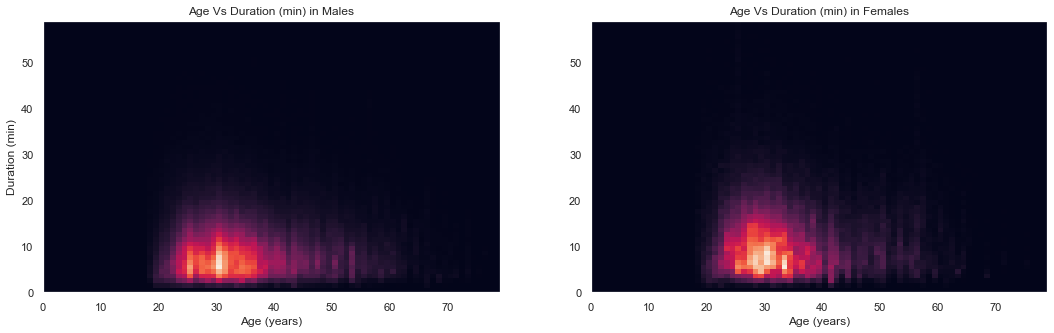

In [99]:
# Plotting age vs average duration Vs. gender (hist2d plot):
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

x_bins = np.arange(0, 80, 1)
y_bins = np.arange(0, 60, 1)

ax1.set_title('Age Vs Duration (min) in Males')
ax1.set_xlabel('Age (years)')
ax1.set_ylabel('Duration (min)')
ax1.hist2d(x=males['age'], y=males['duration_min'], bins=[x_bins, y_bins])


ax2.set_title('Age Vs Duration (min) in Females')
ax2.set_xlabel('Age (years)')
ax2.hist2d(x=females['age'], y=females['duration_min'], bins=[x_bins, y_bins]);

> - Nothing important here!
> - The majority of riders in both groups were ~= 30 years old.
> - The majority of rides in both groups were less than 10 minutes.

In [100]:
df['duration_min'].describe([0.99])

count    849069.000000
mean         11.952883
std          31.008806
min           1.000000
50%           9.000000
99%          54.000000
max        1438.000000
Name: duration_min, dtype: float64

In [101]:
# Capping the duration to the 99th percentile:
p_99 = df['duration_min'].quantile(0.99)
df_ = df.query("duration_min < = @p_99")

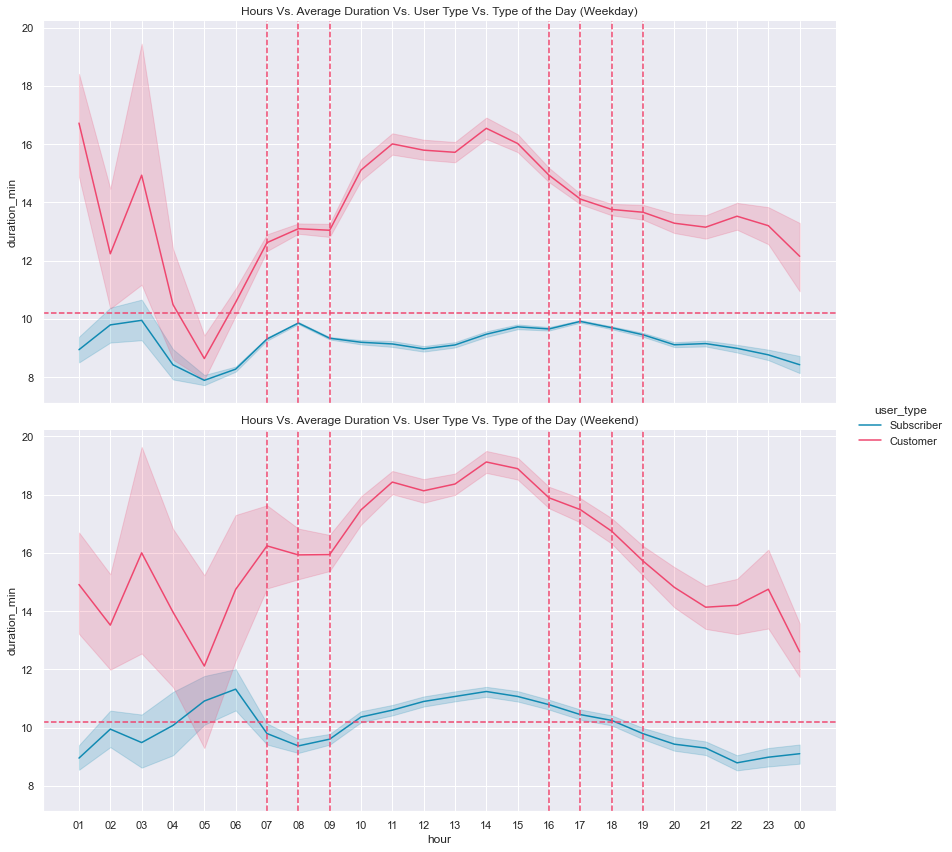

In [102]:
# Plotting hours Vs. average duration Vs. user type Vs. type of the day:
g = sns.relplot(kind='line', data=df_, x='hour', y='duration_min', estimator=np.mean,
                hue='user_type', row='type_of_day', height=6, aspect=2)

g.refline(y=df_['duration_min'].mean(), color=red)
for h in [6, 7, 8, 15, 16, 17, 18]:
    g.refline(x=h, color=red)
    
g.set_titles(row_template='Hours Vs. Average Duration Vs. User Type Vs. Type of the Day ({row_name})');

> - The average duration is generally higher for the customers group.
> - The duration is highly variable outside the rush hours.
> - The variation in duration is higher for the customers group than subscribers group.

In [103]:
# Filtering subscribers:
subscribers = df.query("user_type == 'Subscriber'")
subscribers_pivot = subscribers.pivot_table(index='hour', columns='type_of_day', values='duration_min',
                                            aggfunc='count', fill_value=0)

In [104]:
# Filtering customers:
customers = df.query("user_type == 'Customer'")
customers_pivot = customers.pivot_table(index='hour', columns='type_of_day', values='duration_min',
                                       aggfunc='count', fill_value=0)

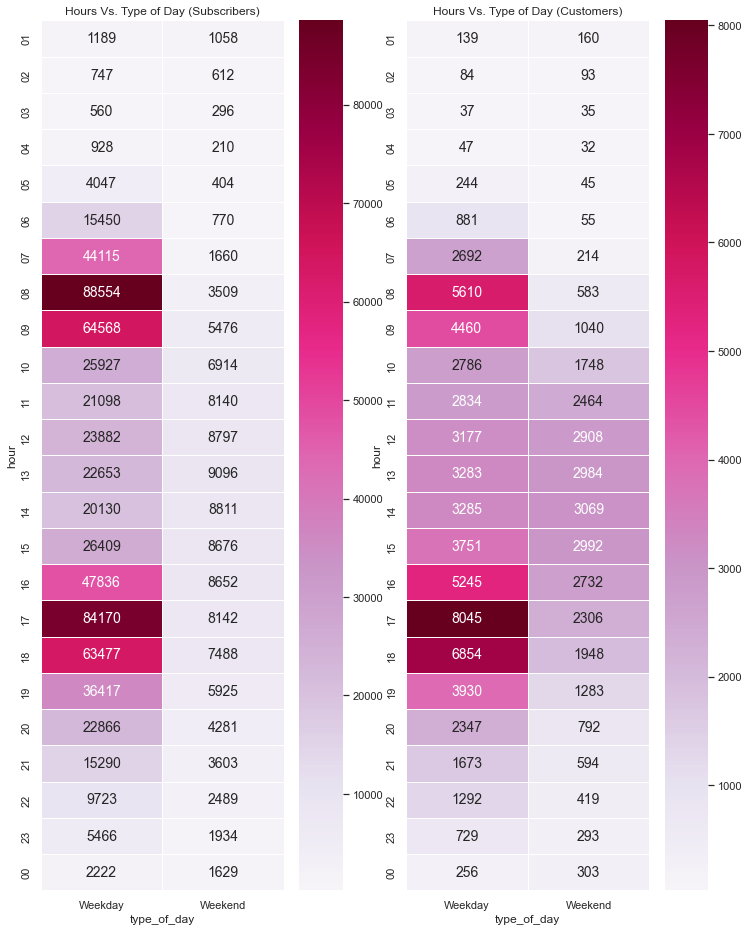

In [105]:
# Plotting Hours Vs. Type of Day Vs. User Type:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 16))

ax1.set_title('Hours Vs. Type of Day (Subscribers)')
sns.heatmap(data=subscribers_pivot, cmap='PuRd', linewidth=1, annot=True, fmt='.0f', annot_kws={'fontsize': 14}, ax=ax1)

ax2.set_title('Hours Vs. Type of Day (Customers)')
sns.heatmap(data=customers_pivot, cmap='PuRd', linewidth=1, annot=True, fmt='.0f', annot_kws={'fontsize': 14}, ax=ax2);

> - Users are more likely to ride during rush hours in weekdays.
> - In weekends the rides are distributed throughout the day (7 am - 12 pm).

## Discussion

> - since there is no user id column, we can't guarantee that these counts represent unique individuals.
> - Since subscribers usually use any service more often, I think that subscribers and cusomers must be weighted differently and it will be crucial to segment our audience later on.
> - All we can conclude that:
>> 1. The service is being used by subscribers about 8 times more often than ordinary customers.
>> 2. The service is being used by males about 3 times more often than females.
> - The age group around 30 years old is the most common pattern.
> - The presence of ages older than 60 years may suggest wrong enteries (ages greater than 100 were dropped at the early cleaning phase).
> - Most bike rides were done by age groups 30-35 > 25-30 > 35-40.
> - About 60% of bike rides were done by people aged around 25-40 years.
> - The frequency of trips along the day suggests  2 rush hours: 7 am : 9 am & 4 pm : 7 pm.
> - The rides reach their nadir between 1-4 am.
> - Another common pattern is that weekdays tend to witness more rides than weekends and winter months witness less rides.
> - About 90% of the rides took less than 20 minutes.
> - About 90% of the rides are less than 3 km long.
> - It turns out that subcribers are more like to ride for a fixed duration (they may use the service for fixed trips) than customers.
> - There is no correlation between age and trip duration.
> - The trip average duration and distribution is nearly the same among all age groups.
> - During weekdays the majority of rides are more likely to be during rush hours (riders may use the srvice for fixed trips), on the other hand the majority of rides in weekends are more likely to be during the period 7 am - 10 pm.
> - Subscribers are more likely to ride during rush hours (they may use the srvice for fixed trips as formerly mentioned), on the other hand customer are more to ride 7 am - 8 pm.
> - During rush hours, the average trip duration is nearly the same with minimal variation.
> - During the rest of the day, there is a relatively higher variation in trip duration.
> - Trip duration tend to be slightly longer and more variale in weekends (Fri evening - Sat - Sun).
> - longer and relatively more variable rides are more likely to occur during weeekends than weekdays.
> - The average duration is generally higher for the customers group.
> - The duration is highly variable outside the rush hours.
> - The variation in duration is higher for the customers group than subscribers group.

## Key Findings for Presentation

> - The service is being used by males about 3 times more often than females.
> - Most bike rides were done by age groups 30-35 > 25-30 > 35-40.
> - About 60% of bike rides were done by people aged around 25-40 years.
> - The frequency of trips along the day suggests  2 rush hours: 7 am : 9 am & 4 pm : 7 pm.
> - The rides reach their nadir between 1-4 am.
> - About 90% of the rides took less than 20 minutes.
> - About 90% of the rides are less than 3 km long.
> - longer and relatively more variable rides are more likely to occur during weeekends than weekdays.

## Resources

> - Udacity advanced data analysis classroom.
> - Pandas in Action [Book].
> - Pandas 1.x Cookbook, 2e [Book].
> - Kimberly Fessel [YouTube].
> - Online documentation for seaborn.